## **Tech Challenge - FASE 02**

## Projeto: Previs√£o de Tend√™ncia do Ibovespa com S√©ries Temporais


---



## **1-Problema**

Voc√™ foi recentemente alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. Sua miss√£o inicial √© desenvolver um modelo preditivo capaz de prever se o √≠ndice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados hist√≥ricos do pr√≥prio √≠ndice. Esse modelo ser√° usado como insumo para alimentar dashboards internos de tomada de decis√£o dos analistas quantitativos da empresa.

## **2- Sobre os Dados**

**Data** => Dia da negocia√ß√£o na bolsa.

**√öltimo** => Valor de fechamento do Ibovespa no final do preg√£o (√∫ltima cota√ß√£o do dia).

**Abertura** => Valor do Ibovespa no in√≠cio do preg√£o.

**M√°xima** => Maior valor atingido pelo √≠ndice durante o dia.

**M√≠nima** => Menor valor atingido pelo √≠ndice durante o dia.

**Vol.** => Volume financeiro negociado no dia (em milh√µes ou bilh√µes de reais).

**Var%** => Varia√ß√£o percentual do √≠ndice em rela√ß√£o ao dia anterior.

## **3- Aquisi√ß√£o e Explora√ß√£o dos Dados**

Instalar e importar as bibliotecas necess√°rias

In [ ]:

!pip install "pandas>=2.0.0"
!pip install tensorflow
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Leitura da base de dados - dados hist√≥ricos do √≠ndice IBOVESPA, dispon√≠veis publicamente: https://br.investing.com/indices/bovespa-historical-data

Requisitos:
‚Ä¢ Per√≠odo selecionado: ‚Äúdi√°rio‚Äù;
‚Ä¢ Intervalo de 01/01/2018 at√© 10/08/2025.

In [ ]:
df = pd.read_csv('/content/Dados Hist√≥ricos - Ibovespa 01-01-18 a 10-08-25.csv', parse_dates=[0], index_col="Data", dayfirst=True)
# Sort the DataFrame by the index (Date) to ensure chronological order
df = df.sort_index()

Visualiza√ß√£o das primeiras e das √∫ltimas linhas do dataframe (df) gerado ap√≥s a leitura da base de dados

In [ ]:
df.head()

√öltimo  Abertura  M√°xima  M√≠nima   Vol.   Var%
Data                                                      
2018-01-02  77.891    76.403  77.909  76.403  2,97M  1,95%
2018-01-03  77.995    77.889  78.414  77.602  3,24M  0,13%
2018-01-04  78.647    77.998  79.135  77.998  3,59M  0,84%
2018-01-05  79.071    78.644  79.071  78.218  2,83M  0,54%
2018-01-08  79.379    79.070  79.395  78.631  2,63M  0,39%

In [ ]:
df.tail()

√öltimo  Abertura   M√°xima   M√≠nima   Vol.    Var%
Data                                                          
2025-08-04  132.971   132.440  133.929  132.440  6,14B   0,40%
2025-08-05  133.151   132.971  134.233  132.682  6,61B   0,14%
2025-08-06  134.538   133.169  135.241  133.169  8,68B   1,04%
2025-08-07  136.528   134.538  137.007  134.533  9,50B   1,48%
2025-08-08  135.913   136.526  136.761  135.659  9,89B  -0,45%

Visualiza√ß√£o das informa√ß√µes sobre o df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1889 entries, 2018-01-02 to 2025-08-08
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   √öltimo    1889 non-null   float64
 1   Abertura  1889 non-null   float64
 2   M√°xima    1889 non-null   float64
 3   M√≠nima    1889 non-null   float64
 4   Vol.      1889 non-null   object 
 5   Var%      1889 non-null   object 
dtypes: float64(4), object(2)
memory usage: 103.3+ KB


In [ ]:
df.shape

(1889, 6)

Verificamos se h√° algum dado nulo no df e somamos todos as linhas que s√£o nulas por coluna

In [ ]:
df.isnull().sum()

√öltimo      0
Abertura    0
M√°xima      0
M√≠nima      0
Vol.        0
Var%        0
dtype: int64

Verificamos se h√° algum dado duplicado no df e somamos todos as linhas que s√£o nulas por coluna

In [ ]:
df.duplicated().sum()

np.int64(0)

Para que as colunas 'Vol.' (Volume) e 'Var%' (Varia√ß√£o Percentual) possam ser utilizadas em an√°lises e no modelo, √© necess√°rio limpar seus dados. Atualmente, elas cont√™m caracteres como 'B', 'M', 'K' e '%', al√©m de v√≠rgulas como separadores decimais, o que impede a convers√£o direta para um formato num√©rico adequado. O c√≥digo a seguir realiza essa limpeza.

In [ ]:
# Limpeza de colunas
def clean_volume(vol_str):
    vol_str = str(vol_str).replace(',', '.')
    if 'B' in vol_str:
        return float(vol_str.replace('B', '')) * 1e9
    elif 'M' in vol_str:
        return float(vol_str.replace('M', '')) * 1e6
    elif 'K' in vol_str:
        return float(vol_str.replace('K', '')) * 1e3
    else:
        return float(vol_str)

df['Vol.'] = df['Vol.'].apply(clean_volume)
df['Var%'] = df['Var%'].replace('%', '', regex=True).str.replace(',', '.').astype(float)

In [ ]:
# Visualizar amostra
df.head()

√öltimo  Abertura  M√°xima  M√≠nima       Vol.  Var%
Data                                                         
2018-01-02  77.891    76.403  77.909  76.403  2970000.0  1.95
2018-01-03  77.995    77.889  78.414  77.602  3240000.0  0.13
2018-01-04  78.647    77.998  79.135  77.998  3590000.0  0.84
2018-01-05  79.071    78.644  79.071  78.218  2830000.0  0.54
2018-01-08  79.379    79.070  79.395  78.631  2630000.0  0.39

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1889 entries, 2018-01-02 to 2025-08-08
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   √öltimo    1889 non-null   float64
 1   Abertura  1889 non-null   float64
 2   M√°xima    1889 non-null   float64
 3   M√≠nima    1889 non-null   float64
 4   Vol.      1889 non-null   float64
 5   Var%      1889 non-null   float64
dtypes: float64(6)
memory usage: 103.3 KB


### **Hist√≥rico do Ibovespa**

Para iniciar nossa an√°lise explorat√≥ria, visualizamos a evolu√ß√£o do pre√ßo de fechamento do Ibovespa ao longo do per√≠odo de 01/01/2018 a 10/08/2025. Este gr√°fico nos oferece uma perspectiva imediata sobre o comportamento hist√≥rico do √≠ndice.
Podemos observar uma tend√™ncia geral de alta ao longo dos anos, indicando uma valoriza√ß√£o do √≠ndice no longo prazo, apesar das flutua√ß√µes inerentes ao mercado.
O gr√°fico tamb√©m evidencia a volatilidade do Ibovespa, com per√≠odos de movimentos mais acentuados, refletindo a din√¢mica e as incertezas do cen√°rio econ√¥mico e pol√≠tico.
Esta visualiza√ß√£o inicial √© crucial para compreendermos a din√¢mica da s√©rie temporal do Ibovespa e identificar padr√µes que ser√£o importantes para a modelagem preditiva.

In [ ]:
df_ultimo = df[["√öltimo"]]

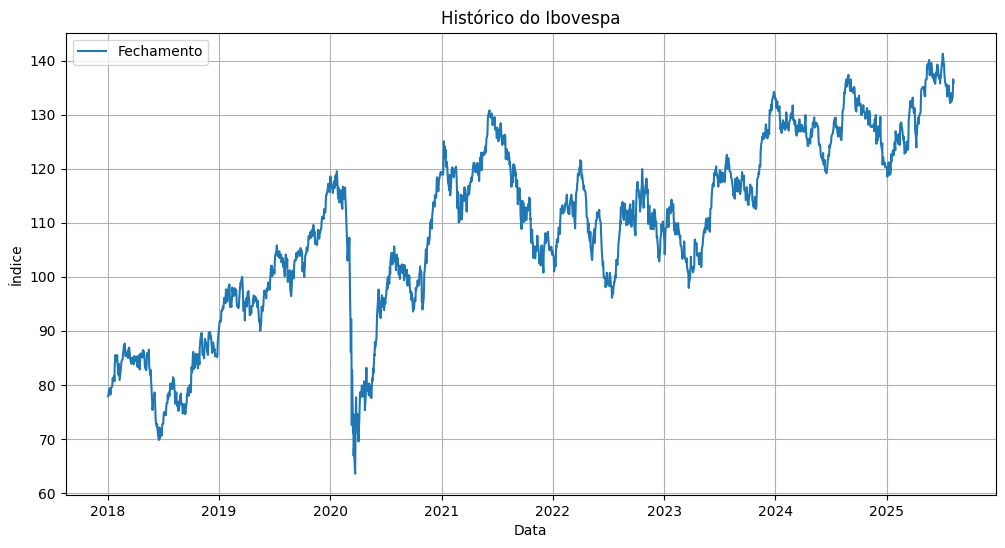

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['√öltimo'], label='Fechamento')
plt.title('Hist√≥rico do Ibovespa')
plt.xlabel('Data')
plt.ylabel('√çndice')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Criar coluna de tend√™ncia (Target)
df['Target'] = (df['√öltimo'].shift(-1) > df['√öltimo']).astype(int)

Adicionar a coluna 'Target' ao DataFrame df e garantir que seja do tipo inteiro.

In [ ]:
# Transformar e garantir tipo
df_long = (
    df.assign(Target=df["Target"].astype(int))
      .melt(id_vars=["Target"],
            value_vars=["Abertura", "M√°xima", "M√≠nima", "√öltimo"],
            var_name="Tipo", value_name="Valor")
)

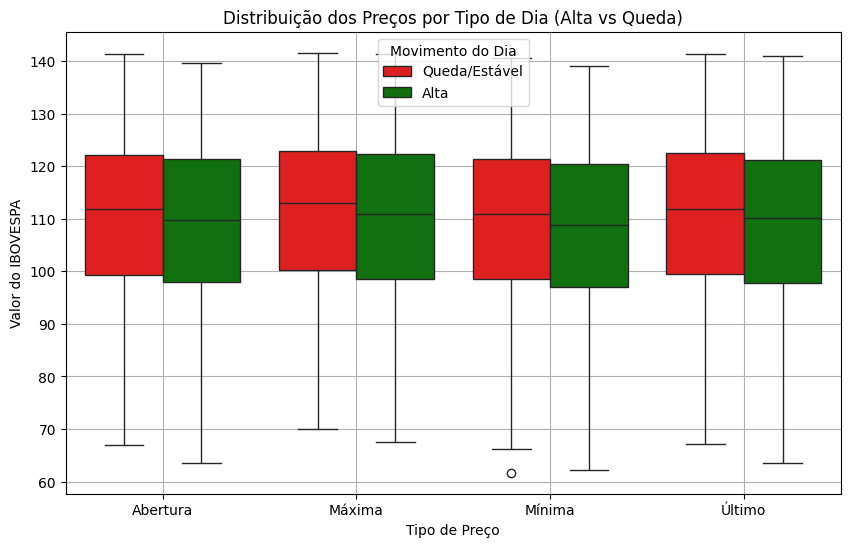

In [ ]:
# Criar o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_long,
    x="Tipo",
    y="Valor",
    hue="Target",
    palette={0: "red", 1: "green"}
)

# Ajustar legenda corretamente
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Queda/Est√°vel", "Alta"], title="Movimento do Dia")

plt.title("Distribui√ß√£o dos Pre√ßos por Tipo de Dia (Alta vs Queda)")
plt.ylabel("Valor do IBOVESPA")
plt.xlabel("Tipo de Pre√ßo")
plt.grid()
plt.show()


O boxplot resultante compara visualmente a distribui√ß√£o dos pre√ßos de 'Abertura', 'M√°xima', 'M√≠nima' e '√öltimo' para os dias em que o Ibovespa fechou em alta (Alta - verde) versus os dias em que fechou em baixa ou est√°vel (Queda/Est√°vel - vermelho). Isso ajuda a entender como o intervalo e a mediana desses pre√ßos diferem com base no movimento do mercado no dia seguinte.

## **4- An√°lise Explorat√≥ria (EDA)**

**4.1 - Decomposi√ß√£o sazonal - seasonal_decompose**

A decomposi√ß√£o sazonal do Ibovespa nos permite abrir a s√©rie temporal em ‚Äúcamadas‚Äù para entender melhor como o √≠ndice se comporta ao longo do tempo. O gr√°fico √© dividido em quatro partes:

**Observed (Observado)**

O primeiro painel mostra a s√©rie original da coluna "√öltimo", ou seja, o pre√ßo de fechamento di√°rio do Ibovespa exatamente como registrado nos dados. Aqui vemos todas as oscila√ß√µes, misturando tend√™ncias, padr√µes c√≠clicos e ru√≠dos.

**Trend (Tend√™ncia)**

O segundo painel destaca o movimento de longo prazo, suavizando ru√≠dos e ciclos curtos. Ele revela a dire√ß√£o predominante do √≠ndice ‚Äî per√≠odos de valoriza√ß√£o sustentada (tend√™ncia de alta), quedas prolongadas ou momentos de lateraliza√ß√£o.

**Seasonal (Sazonalidade)**

O terceiro painel isola padr√µes que se repetem em intervalos regulares, definidos pelo par√¢metro period. No exemplo com period=12, estamos capturando ciclos que se repetem aproximadamente a cada 12 dias √∫teis, o que pode n√£o refletir uma sazonalidade t√≠pica do mercado (geralmente anual ou semanal). Ajustar o per√≠odo para 252 ‚Äî o n√∫mero aproximado de preg√µes em um ano ‚Äî permitiria observar um padr√£o m√©dio anual de comportamento.

**Residual (Res√≠duo)**

O √∫ltimo painel mostra o que sobra ap√≥s remover tend√™ncia e sazonalidade: o ru√≠do. S√£o varia√ß√µes imprevis√≠veis, muitas vezes associadas a eventos pontuais ou volatilidade de curto prazo. Quando esse res√≠duo se distribui de forma aleat√≥ria em torno de zero, significa que os principais padr√µes foram bem capturados pelos outros componentes.

Essa decomposi√ß√£o ajuda a separar o que √© movimento estrutural, o que √© padr√£o recorrente e o que √© imprevis√≠vel, facilitando tanto a an√°lise quanto a modelagem preditiva.

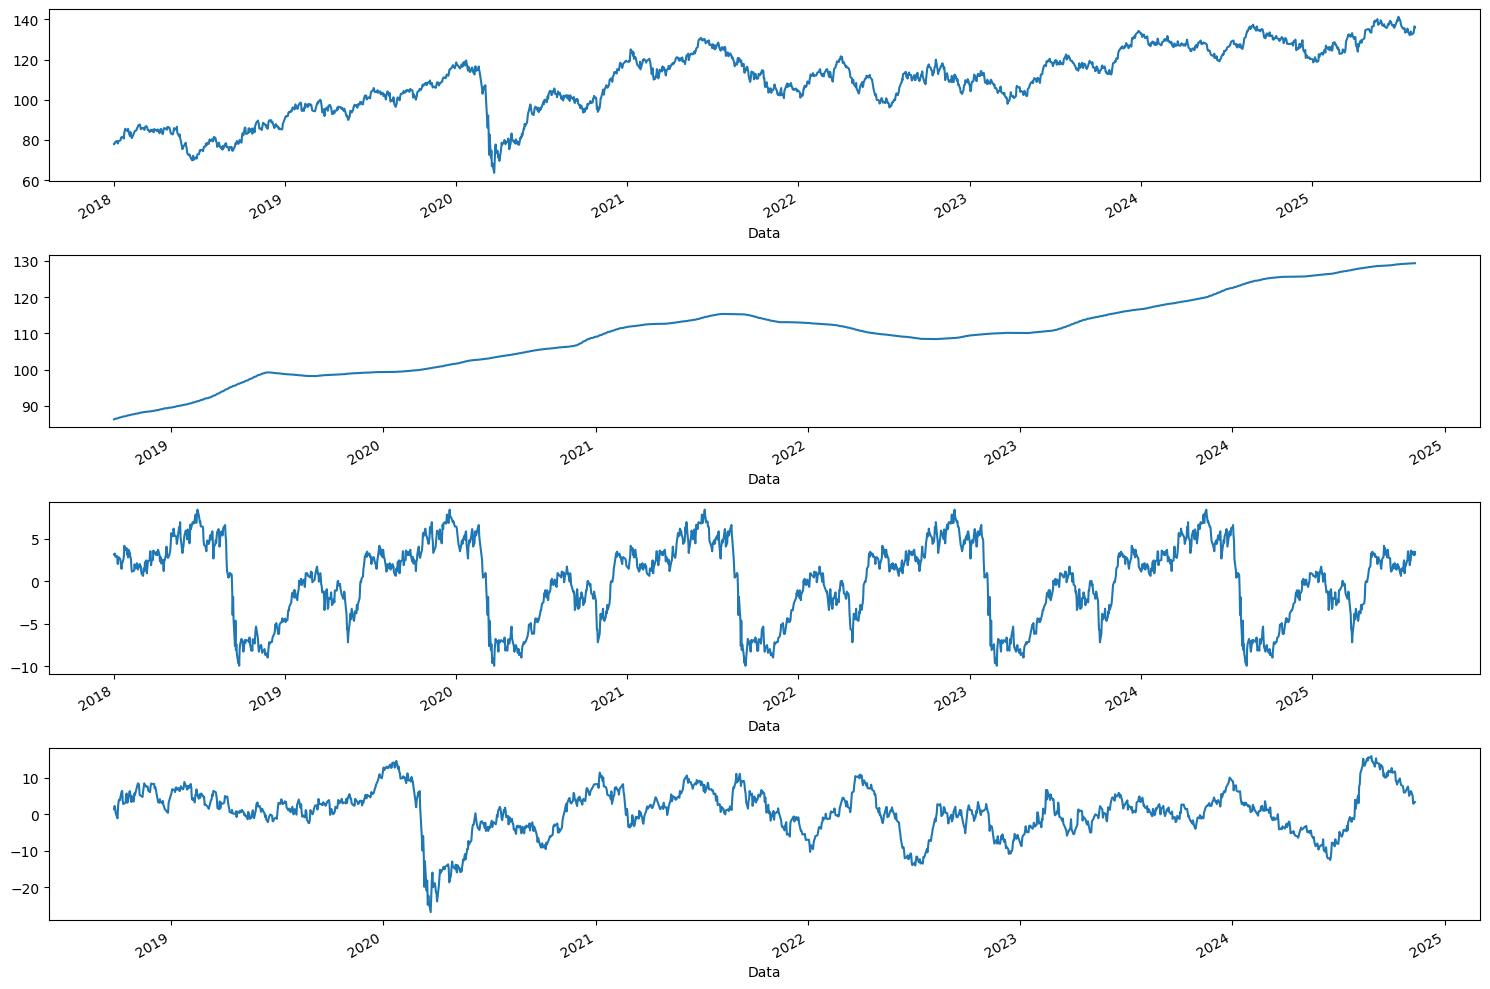

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_ultimo, period=365)
# Representa√ß√£o gr√°fica da decomposi√ß√£o da s√©rie temporal

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultado.observed.plot(ax=ax1) #observado
resultado.trend.plot(ax=ax2) #tend√™ncia
resultado.seasonal.plot(ax=ax3) #sazonalidade
resultado.resid.plot(ax=ax4) #res√≠duo

plt.tight_layout()

**4.2 - S√©rie temporal: Estacion√°ria ou N√£o Estacion√°ria?**

Executamos o teste Augmented Dickey-Fuller (ADF) na s√©rie temporal dos dados da coluna '√öltimo' para verificar se a s√©rie √© estacion√°ria.

In [ ]:
sns.set_style('darkgrid')

In [ ]:
x = df_ultimo.√öltimo.values

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(x)

print("Teste ADF")
print(f"Teste Estat√≠stico: {result[0]}")
print(f"P-value: {result[1]}")
print("Valores cr√≠ticos:")

for key, value in result[4].items():
    print(f"\t{key}: {value}")


if result[1] < 0.05:
    print("S√©rie estacion√°ria")
else:
    print("S√©rie n√£o estacion√°ria")

Teste ADF
Teste Estat√≠stico: -2.1452645257037926
P-value: 0.22670710817459777
Valores cr√≠ticos:
	1%: -3.433833112339179
	5%: -2.8630785975831463
	10%: -2.5675890926324128
S√©rie n√£o estacion√°ria


O Teste ADF determinou que a s√©rie temporal √© uma S√©rie N√£o Estacion√°ria.

Essa defini√ß√£o √© feita de acordo o valor do p-value. Se o p-value for menor que 0.05 (n√≠vel de signific√¢ncia), rejeitamos a hip√≥tese nula (H0). A hip√≥tese nula do teste ADF √© que a s√©rie temporal n√£o √© estacion√°ria. Portanto, se o p-value for menor que 0.05, conclu√≠mos que a s√©rie √© estacion√°ria. Caso contr√°rio, se o p-value for maior ou igual a 0.05, n√£o rejeitamos a hip√≥tese nula e conclu√≠mos que a s√©rie n√£o √© estacion√°ria.

No teste ADF do nosso notebook, o p-value foi de aproximadamente 0.227 (ou 22.7%). Como 0.227 √© maior que 0.05, n√£o rejeitamos a hip√≥tese nula de que a s√©rie n√£o √© estacion√°ria. Por isso, conclu√≠mos que a s√©rie do Ibovespa √© n√£o estacion√°ria.

**4.3 - An√°lise da Evolu√ß√£o do Pre√ßo de Abertura com M√©dia M√≥vel (12 dias)**

üìàO gr√°fico abaixo mostra a evolu√ß√£o da vari√°vel "Abertura" do √≠ndice IBOVESPA entre os anos de 2018 e 2025, acompanhada de uma M√©dia M√≥vel Simples (SMA) de 12 dias. Embora a s√©rie cubra um longo per√≠odo, a m√©dia m√≥vel aplicada tem como foco o curto prazo, suavizando pequenas oscila√ß√µes di√°rias.

No gr√°fico:

A linha azul representa os valores reais de Abertura registrados diariamente;

A linha vermelha mostra a m√©dia m√≥vel de 12 dias, revelando pequenas tend√™ncias locais no meio de um contexto temporal mais amplo.

Esta visualiza√ß√£o permite identificar padr√µes de curto prazo dentro de uma perspectiva de longo prazo, sendo especialmente √∫til para observar momentos de acelera√ß√£o, desacelera√ß√£o ou revers√£o no comportamento do mercado.

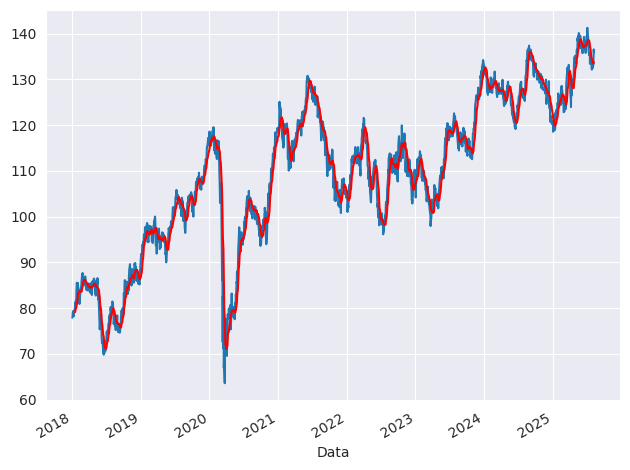

In [ ]:
ma = df_ultimo.rolling(12).mean() # m√©dia m√≥vel

f, ax = plt.subplots()
df_ultimo.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

**4.4 - S√©rie Temporal (Escala Logar√≠tmica) com M√©dia M√≥vel (12 dias)**

Fizemos uma transforma√ß√£o logar√≠tmica na s√©rie temporal dos valores de fechamento do Ibovespa ('√öltimo') e calculamos a m√©dia m√≥vel de 12 dias sobre essa s√©rie logar√≠tmica.

O gr√°fico resultante mostra a s√©rie temporal do Ibovespa em escala logar√≠tmica (linha azul) e sua m√©dia m√≥vel de 12 dias (linha vermelha). Essa visualiza√ß√£o ajuda a observar a tend√™ncia e os ciclos na s√©rie ap√≥s a aplica√ß√£o da transforma√ß√£o logar√≠tmica.

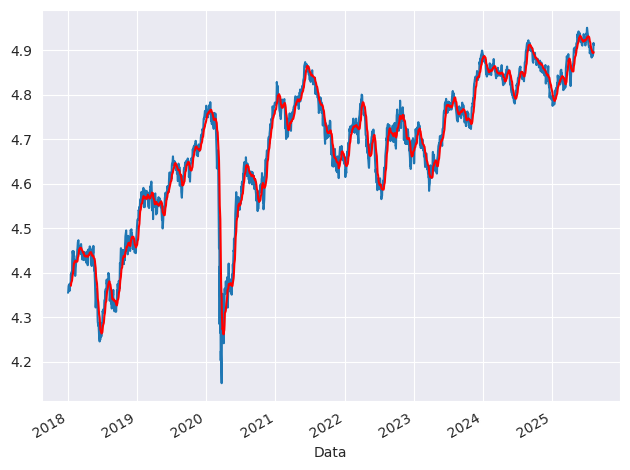

In [ ]:
df_log = np.log(df_ultimo)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

**4.5 - S√©rie Temporal (Escala Logar√≠tmica e Sem Tend√™ncia) com M√©dia M√≥vel e Desvio Padr√£o**

Subtra√≠mos a m√©dia m√≥vel logar√≠tmica da s√©rie logar√≠tmica original para remover a tend√™ncia de curto prazo e, em seguida, calculamos a m√©dia m√≥vel e o desvio padr√£o da s√©rie resultante. E plotamos essas tr√™s s√©ries.

O gr√°fico abaixo ajuda a visualizar a s√©rie ap√≥s a remo√ß√£o da tend√™ncia de curto prazo, a m√©dia m√≥vel da s√©rie (que idealmente deve ser plana e pr√≥xima de zero para uma s√©rie estacion√°ria) e a volatilidade m√≥vel.

√â um passo importante na an√°lise de s√©ries temporais para identificar se a s√©rie se tornou estacion√°ria ap√≥s as transforma√ß√µes.

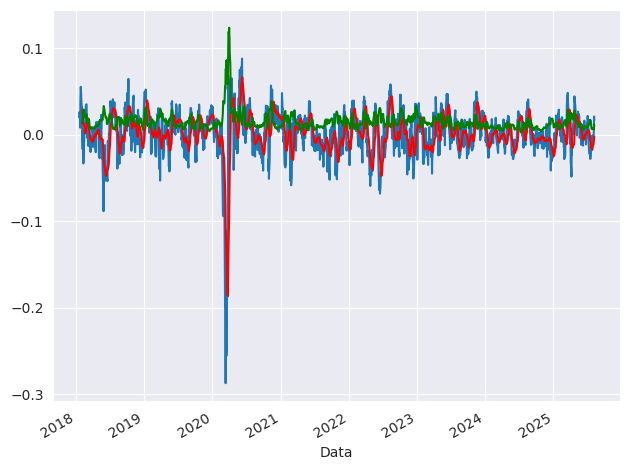

In [ ]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

Executamos novamente o teste Augmented Dickey-Fuller (ADF), mas desta vez na s√©rie temporal df_s, que √© a s√©rie do pre√ßo de fechamento do Ibovespa ap√≥s aplicar a transforma√ß√£o logar√≠tmica e remover a tend√™ncia de curto prazo.

O objetivo de executar o teste ADF nesta s√©rie transformada √© verificar se as etapas de transforma√ß√£o logar√≠tmica e remo√ß√£o da tend√™ncia foram suficientes para tornar a s√©rie estacion√°ria.

In [ ]:
x_s = df_s.√öltimo.values
result_s = adfuller(x_s)

print("Teste ADF")
print(f"Teste Estat√≠stico: {result_s[0]}")
print(f"P-value: {result_s[1]}")
print("Valores cr√≠ticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

if result_s[1] < 0.05:
    print("S√©rie estacion√°ria")
else:
    print("S√©rie n√£o estacion√°ria")

Teste ADF
Teste Estat√≠stico: -10.983312127341918
P-value: 7.365038322462234e-20
Valores cr√≠ticos:
	1%: -3.433851764270508
	5%: -2.863086831883029
	10%: -2.5675934770796993
S√©rie estacion√°ria


Realizamos a diferencia√ß√£o da s√©rie temporal, calculamos a m√©dia m√≥vel e o desvio padr√£o da s√©rie diferenciada e, em seguida, executamos o teste ADF nela para verificar a estacionaridade.

Os resultados do teste ADF mostraram que a s√©rie diferenciada agora √© estacion√°ria (p-value muito baixo). O gr√°fico tamb√©m sugere isso, pois a m√©dia e o desvio padr√£o parecem mais constantes ao longo do tempo.

Teste ADF
Teste Estat√≠stico: -13.507783361374488
P-value: 2.8926911326599057e-25
Valores cr√≠ticos:
	1%: -3.433887758938708
	5%: -2.8631027223655448
	10%: -2.567601938172921
S√©rie estacion√°ria


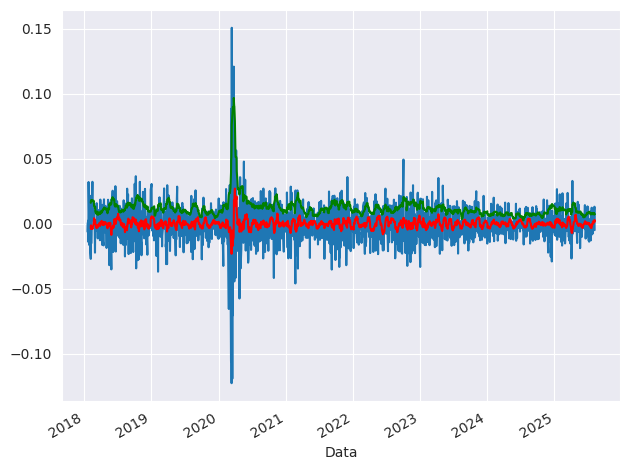

In [ ]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

x_diff = df_diff.√öltimo.dropna().values
result_diff = adfuller(x_diff)

print("Teste ADF")
print(f"Teste Estat√≠stico: {result_diff[0]}")
print(f"P-value: {result_diff[1]}")
print("Valores cr√≠ticos:")

for key, value in result_diff[4].items():
    print(f"\t{key}: {value}")

if result_diff[1] < 0.05:
    print("S√©rie estacion√°ria")
else:
    print("S√©rie n√£o estacion√°ria")

Calculamos e armazenamos as fun√ß√µes de autocorrela√ß√£o (ACF) e autocorrela√ß√£o parcial (PACF) para a s√©rie temporal diferenciada (df_diff)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_diff.dropna(), nlags=360)
lag_pacf = pacf(df_diff.dropna(), nlags=360, method='yw')

Os resultados desses c√°lculos (lag_acf e lag_pacf) s√£o arrays NumPy que cont√™m os valores da ACF e PACF para cada lag, respectivamente. Estes resultados ser√£o usados nos pr√≥ximos passos para plotar os gr√°ficos de ACF e PACF, que s√£o ferramentas visuais essenciais na identifica√ß√£o dos par√¢metros (p e q) para os modelos.

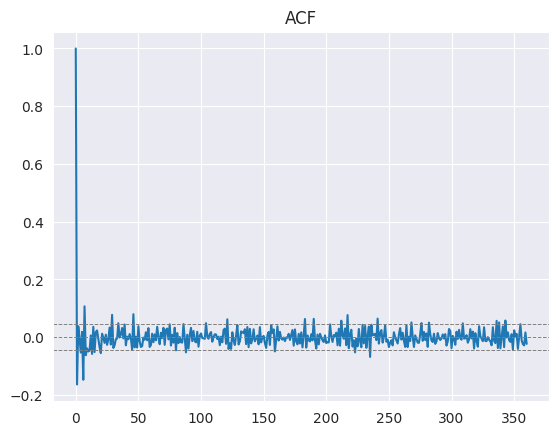

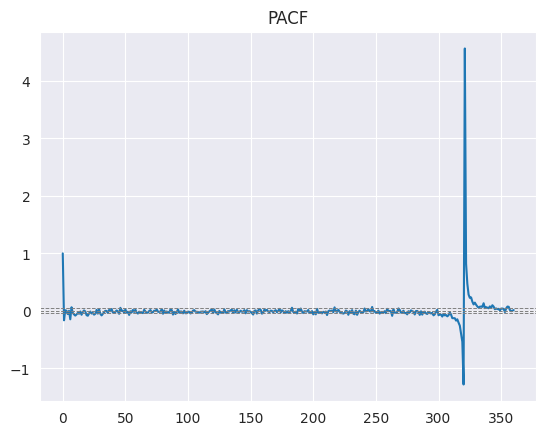

In [ ]:
#5% ACF
plt.plot(lag_acf)
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 0, linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 0, linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)

plt.title("PACF")
plt.show()

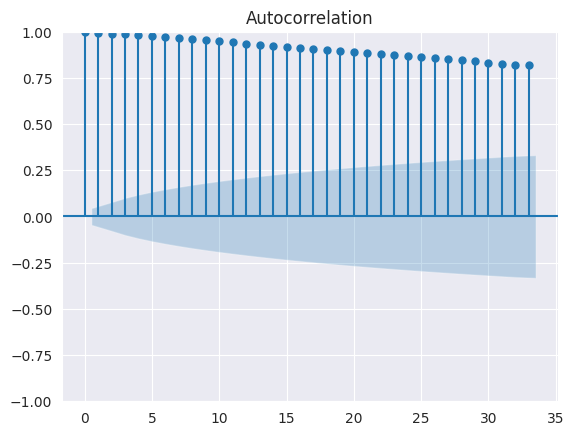

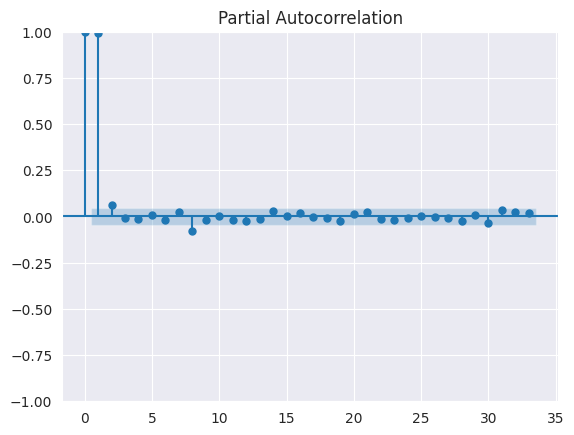

In [ ]:
#plotar os gr√°ficos ACF e PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_ultimo.√öltimo)
plot_pacf(df_ultimo.√öltimo)
plt.show()

4.6 - **Histograma com KDE**

Este histograma com KDE mostra a distribui√ß√£o dos valores de fechamento do Ibovespa ('√öltimo') ao longo do per√≠odo analisado. Observamos que a distribui√ß√£o n√£o √© unimodal (com um √∫nico pico), mas sim bimodal, apresentando um pico principal na faixa de valores mais altos (acima de 110.000) e um pico secund√°rio em valores significativamente mais baixos. A presen√ßa desse segundo pico em valores baixos pode indicar a exist√™ncia de outliers ou a necessidade de uma revis√£o mais aprofundada da escala ou da limpeza dos dados em alguns pontos, mesmo ap√≥s os ajustes j√° realizados.

<Axes: xlabel='√öltimo', ylabel='Count'>

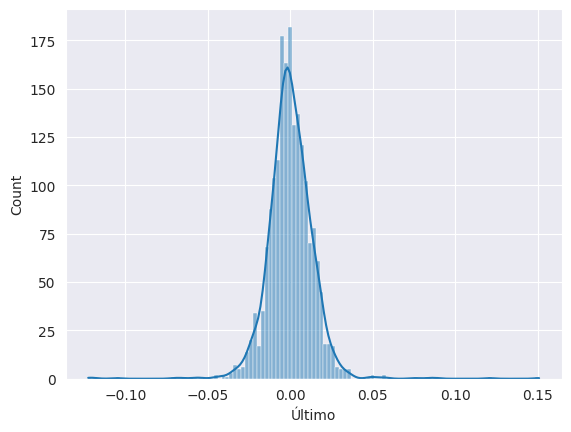

In [ ]:
sns.histplot(data=df_diff, x="√öltimo", kde=True)

## **5- Engenharia de Atributos**

A se√ß√£o de Engenharia de Atributos √© crucial para criar novas vari√°veis (features) a partir dos dados brutos que possam ajudar o modelo a aprender padr√µes e fazer previs√µes.

Aqui est√° a explica√ß√£o de cada etapa:

1- M√©dias M√≥veis (Moving Averages - MM_5 e MM_10):

*   MM_5 - Calcula a m√©dia m√≥vel do pre√ßo de fechamento (√öltimo) para uma janela de 5 dias. Essa m√©dia m√≥vel suaviza a s√©rie temporal e ajuda a identificar a dire√ß√£o da tend√™ncia de curto prazo. Para cada dia, a MM_5 √© a m√©dia dos pre√ßos de fechamento dos √∫ltimos 5 dias (incluindo o dia atual).

*   MM_10 - Calcula a m√©dia m√≥vel do pre√ßo de fechamento para uma janela de 10 dias. Uma m√©dia m√≥vel de 10 dias √© mais lenta para reagir a mudan√ßas de pre√ßo do que a de 5 dias e √© usada para observar a tend√™ncia de m√©dio prazo.

Prop√≥sito: M√©dias m√≥veis s√£o indicadores t√©cnicos comuns que ajudam a identificar tend√™ncias e potenciais pontos de suporte ou resist√™ncia. Ao inclu√≠-las como features, estamos dando ao modelo informa√ß√µes sobre a din√¢mica recente do pre√ßo.

2- Varia√ß√£o Percentual Di√°ria (Retorno): Calcula a varia√ß√£o percentual do pre√ßo de fechamento de um dia para o outro.

Prop√≥sito: O retorno di√°rio √© uma m√©trica fundamental em finan√ßas que mostra a performance percentual do ativo em um dia. √â uma medida de volatilidade e dire√ß√£o do movimento de pre√ßo. Incluir o retorno ajuda o modelo a entender a magnitude e a dire√ß√£o das mudan√ßas de pre√ßo recentes. Note que o primeiro valor ser√° NaN (N√£o √© um N√∫mero), pois n√£o h√° um dia anterior para calcular a varia√ß√£o.

3- Criar Coluna de Tend√™ncia (Target): Esta √© a cria√ß√£o da sua vari√°vel alvo, que voc√™ quer prever. Deslocamos a coluna '√öltimo' uma posi√ß√£o para cima. Isso significa que, para cada linha, teremos o pre√ßo de fechamento do dia seguinte.

Tamb√©m comparamos o pre√ßo de fechamento do dia seguinte com o pre√ßo de fechamento do dia atual. O resultado foi uma s√©rie de valores booleanos (True ou False). Ser√° True se o pre√ßo de fechamento do dia seguinte for maior que o do dia atual (indicando alta), e False caso contr√°rio (indicando baixa ou estabilidade).

Convertemos os valores booleanos para inteiros: True se torna 1 e False se torna 0.

Prop√≥sito: Esta coluna 'Target' √© a vari√°vel que queremos prever com o nosso modelo. Target = 1 significa que o Ibovespa fechou em alta no dia seguinte, e Target = 0 significa que ele fechou em baixa ou no mesmo patamar. √â a binariza√ß√£o do movimento de pre√ßo para a sua tarefa de classifica√ß√£o.

Conclus√£o: Em suma, a engenharia de atributos criou vari√°veis que capturam a tend√™ncia de m√©dio/curto prazo (M√©dias M√≥veis), a volatilidade e a dire√ß√£o da mudan√ßa di√°ria (Retorno), e a vari√°vel que queremos prever (Target), baseada no movimento do dia seguinte. Essas novas features fornecem ao modelo informa√ß√µes mais ricas do que apenas os pre√ßos brutos para realizar a previs√£o.

In [ ]:
#criar um novo DataFrame vazio
dataset = pd.DataFrame()

In [ ]:
#criar a coluna "√öltimo"
dataset["√öltimo"] = df["√öltimo"]

#calcula a diferen√ßa entre o pre√ßo de fechamento de cada dia e o pre√ßo de fechamento do dia anterior no DataFrame original df
delta = df['√öltimo'].diff()

#Define um limite (threshold) de 0.003. Usado para determinar se uma varia√ß√£o percentual √© considerada uma "alta" significativa para a cria√ß√£o da vari√°vel Target
threshold = 0.003  # desconsiderando varia√ß√µes menores que 0.3%
dataset['Target'] = (delta > threshold).astype(int)  # 1 se a varia√ß√£o for maior que o threshold, 0 caso contr√°rio

#remove a √∫ltima linha, pois o alvo para o √∫ltimo dia n√£o est√° dispon√≠vel
dataset = dataset[:-1]

#cria duas novas colunas no seu DataFrame dataset, baseadas nos valores do dia anterior
dataset["Delta"] = delta.shift(1)
dataset['Retorno'] = dataset['√öltimo'].pct_change().shift(1)

In [ ]:
#fun√ß√µes agregadoras

def make_lags(series: pd.Series, n_lags):
    return series.shift(n_lags)


def make_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f"{column}_lag{i}"] = df[column].shift(i)
    return df

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def compute_bollinger(series, window=20, num_std=2):
    ma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return upper, lower

In [ ]:
#criar N lags de 1 a N
n_lags = 30

#remova ap√≥s os lags serem criados
dataset = make_n_lags(dataset, n_lags, "Delta")

# Explica√ß√£o das Features Criadas

As vari√°veis extra√≠das do dataset foram constru√≠das para capturar diferentes dimens√µes do comportamento do ativo.  
Cada grupo de features conta uma parte da ‚Äúhist√≥ria‚Äù do mercado:

---

### 1. Extremos do Pre√ßo
- **M√°xima, M√≠nima (diff + shift):** Capturam como os extremos mudam dia a dia, refletindo o humor do mercado.  
- **Spread:** Diferen√ßa entre m√°xima e m√≠nima, mostrando a batalha entre compradores e vendedores.

---

### 2. Volatilidade
- **Volatilidade (10D std):** Batimento card√≠aco do mercado no curto prazo.  
- **TR & ATR (True Range e Average True Range):** Press√£o intradi√°ria, considerando gaps e alongamentos.  
- **Volatilidades 10D, 22D, 66D:** Diferentes horizontes de oscila√ß√£o (curto, m√©dio e longo prazo).  
- **Historical Volatility (20D, 60D):** Variabilidade hist√≥rica baseada nos retornos di√°rios.

---

### 3. Abertura e Volume
- **Abertura (diff):** Mostra gaps de expectativas entre dias.  
- **Volume (diff):** Mudan√ßa no interesse dos investidores.  
- **Volume_MM20:** Tend√™ncia do volume ao longo do tempo.

---

### 4. Indicadores de Tend√™ncia e Momentum
- **Momentum (5D):** Impulso de curt√≠ssimo prazo.  
- **M√©dias m√≥veis (5 a 200 dias):** Tend√™ncias de diferentes horizontes, de curto a secular.  
- **MACD & Signal:** Conflito entre curto e longo prazo; cruzamentos indicam potenciais revers√µes.

---

### 5. Indicadores de Sentimento
- **RSI (14D):** Term√≥metro da fadiga do mercado (sobrecompra/sobrevenda).  
- **Bandas de Bollinger:** Funcionam como el√°sticos que prendem o pre√ßo, sinalizando press√µes e poss√≠veis revers√µes.

---

### 6. Retornos
- **Return_5D, Return_10D, Return_20D:** Retornos acumulados em diferentes horizontes, mem√≥ria recente do mercado.  
- **Daily_Return:** Varia√ß√£o di√°ria do pre√ßo.

---

### Resumo
As features criadas funcionam como uma **cr√≥nica da vida do ativo**:
- Captam **curto prazo** (momentum, volatilidade curta, retornos recentes).  
- Revelam o **m√©dio/longo prazo** (MA200, volatilidade hist√≥rica).  
- Exp√µem o **sentimento e emo√ß√£o do mercado** (RSI, MACD, Volume).  

No conjunto, elas ajudam o modelo a distinguir per√≠odos de calma e per√≠odos de tempestade.


In [ ]:
#utilizamos o .diff() como recurso de estacionariza√ß√£o
dataset["M√°xima"] = df["M√°xima"].diff().shift(1)
dataset["M√≠nima"] = df["M√≠nima"].diff().shift(1)

dataset["Spread"] = dataset["M√°xima"] - dataset["M√≠nima"]
dataset["Volatilidade"] = dataset["Target"].rolling(window=10).std()

dataset["Abertura"] = df["Abertura"].diff()
dataset["Volume"] = df["Vol."].diff()

dataset['High_Prev_Close'] = abs(dataset['M√°xima'] - dataset['√öltimo'].shift(1))
dataset['Low_Prev_Close'] = abs(dataset['M√≠nima'] - dataset['√öltimo'].shift(1))
dataset['TR'] = dataset[['Spread', 'High_Prev_Close', 'Low_Prev_Close']].max(axis=1)
dataset['ATR'] = dataset['TR'].ewm(span=14, adjust=False).mean().shift(1)

dataset['Volume_MM20'] = dataset['Volume'].rolling(window=10).mean().shift(1) # Corrigido para 10 dias
dataset['RSI_14'] = compute_rsi(dataset['Delta'], 14)  # √çndice de For√ßa Relativa
dataset['Momentum_5'] = dataset['Delta'] - dataset['Delta'].shift(5)
dataset['Volatility_10'] = dataset['Delta'].rolling(window=10).std()
dataset['Volatilidade_22'] = dataset['Delta'].rolling(22).std()
dataset['Volatilidade_66'] = dataset['Delta'].rolling(66).std()

# Novas m√©tricas adicionadas/descomentadas:

# Retornos passados em diferentes per√≠odos
dataset['Return_5D'] = dataset['√öltimo'].pct_change(periods=5).shift(1) # Retorno de 5 dias atr√°s
dataset['Return_10D'] = dataset['√öltimo'].pct_change(periods=10).shift(1) # Retorno de 10 dias atr√°s
dataset['Return_20D'] = dataset['√öltimo'].pct_change(periods=20).shift(1) # Retorno de 20 dias atr√°s

# Volatilidade hist√≥rica (usando retorno di√°rio)
dataset['Daily_Return'] = dataset['√öltimo'].pct_change().shift(1)
dataset['Historical_Volatility_20D'] = dataset['Daily_Return'].rolling(window=20).std().shift(1)
dataset['Historical_Volatility_60D'] = dataset['Daily_Return'].rolling(window=60).std().shift(1)

# MACD e Signal (descomentado)
dataset['MACD'], dataset['Signal'] = compute_macd(dataset['√öltimo'])

# M√©dias M√≥veis do pre√ßo de fechamento ('√öltimo')
for win in [5, 10, 20, 50, 100, 200]:
    dataset[f'Ultimo_MA_{win}'] = dataset['√öltimo'].rolling(window=win).mean().shift(1)


dataset['BB_Upper'], dataset['BB_Lower'] = compute_bollinger(dataset['√öltimo'])

In [ ]:
# m√©dias m√≥veis
for win in [5, 10, 22, 66, 132, 252]:
    dataset[f'MA_{win}'] = dataset['Abertura'].rolling(window=win).mean()

In [ ]:
dataset.drop("√öltimo", axis=1, inplace=True)
df_model = dataset.dropna().copy()

In [ ]:
df_model

Target  Delta   Retorno  Delta_lag1  Delta_lag2  Delta_lag3  \
Data                                                                      
2019-01-11       0  0.193  0.002062       1.581       0.333      -0.142   
2019-01-14       1 -0.148 -0.001578       0.193       1.581       0.333   
2019-01-15       0  0.816  0.008713      -0.148       0.193       1.581   
2019-01-16       1 -0.418 -0.004424       0.816      -0.148       0.193   
2019-01-17       1  0.337  0.003583      -0.418       0.816      -0.148   
...            ...    ...       ...         ...         ...         ...   
2025-08-01       0 -0.919 -0.006859       1.264       0.597      -1.395   
2025-08-04       1 -0.634 -0.004764      -0.919       1.264       0.597   
2025-08-05       1  0.534  0.004032      -0.634      -0.919       1.264   
2025-08-06       1  0.180  0.001354       0.534      -0.634      -0.919   
2025-08-07       1  1.387  0.010417       0.180       0.534      -0.634   

            Delta_lag4  Delta_lag5  Delta_lag6  Delta_lag7  ...  \
Data                                                        ...   
2019-01-11       0.277       0.552       3.125       2.427  ...   
2019-01-14      -0.142       0.277       0.552       3.125  ...   
2019-01-15       0.333      -0.142       0.277       0.552  ...   
2019-01-16       1.581       0.333      -0.142       0.277  ...   
2019-01-17       0.193       1.581       0.333      -0.142  ...   
...                ...         ...         ...         ...  ...   
2025-08-01      -0.284      -1.560       1.332      -0.131  ...   
2025-08-04      -1.395      -0.284      -1.560       1.332  ...   
2025-08-05       0.597      -1.395      -0.284      -1.560  ...   
2025-08-06       1.264       0.597      -1.395      -0.284  ...   
2025-08-07      -0.919       1.264       0.597      -1.395  ...   

            Ultimo_MA_100  Ultimo_MA_200    BB_Upper    BB_Lower    MA_5  \
Data                                                                       
2019-01-11       83.43844      81.567520   95.160397   82.443903  0.4458   
2019-01-14       83.60006      81.614990   95.937045   82.472655  0.3600   
2019-01-15       83.75878      81.662475   96.537660   82.579940  0.5550   
2019-01-16       83.92856      81.708915   97.135597   82.637503  0.4048   
2019-01-17       84.10430      81.758995   97.826670   82.736530  0.1588   
...                   ...            ...         ...         ...     ...   
2025-08-01      134.40370     130.149440  139.145845  130.800855 -0.1800   
2025-08-04      134.48288     130.161815  138.323225  130.971575 -0.2196   
2025-08-05      134.57752     130.174905  137.343404  131.336196  0.1682   
2025-08-06      134.67039     130.190700  136.812086  131.573214  0.0934   
2025-08-07      134.75940     130.208365  136.758684  131.605116  0.1102   

             MA_10     MA_22     MA_66    MA_132    MA_252  
Data                                                        
2019-01-11  0.8122  0.221500  0.219030  0.169705  0.069060  
2019-01-14  0.8504  0.218000  0.227576  0.174515  0.062524  
2019-01-15  0.9005  0.289045  0.194697  0.171932  0.065381  
2019-01-16  0.6170  0.369955  0.163364  0.161318  0.061163  
2019-01-17  0.3382  0.362409  0.173045  0.163220  0.060806  
...            ...       ...       ...       ...       ...  
2025-08-01 -0.2642 -0.303000 -0.031773  0.076288  0.021540  
2025-08-04 -0.0942 -0.300500 -0.040212  0.068902  0.021782  
2025-08-05 -0.1209 -0.361682 -0.031758  0.075803  0.027111  
2025-08-06 -0.0867 -0.368000 -0.029727  0.080955  0.021893  
2025-08-07 -0.0819 -0.225136  0.015742  0.091629  0.028345  

[1636 rows x 71 columns]

# **6- Prepara√ß√£o da Base para Previs√£o**

Divimos o DataFrame df_model em conjuntos de treino e teste para a modelagem, utilizando uma abordagem temporal.

In [ ]:
# utilizando os √∫ltimos 30 dias como teste
test_days = 30
train = df_model.iloc[:-test_days].copy()
test = df_model.iloc[-test_days:].copy()

predictors = list(train.columns)
predictors.remove('Target')

X_train, X_test = train[predictors], test[predictors]
y_train, y_test = train['Target'], test['Target']

In [ ]:
#usamos o TimeSeriesSplit do Scikit-learn para fazer uma valida√ß√£o cruzada para dados de s√©ries temporais.
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
#verificamos a presen√ßa de valores infinitos (inf e -inf) em cada coluna do DataFrame df_model e somamos quantos valores infinitos existem em cada coluna.
print("Infinite values in each column:")
print(df_model.isin([np.inf, -np.inf]).sum())

Infinite values in each column:
Target        0
Delta         0
Retorno       0
Delta_lag1    0
Delta_lag2    0
             ..
MA_10         0
MA_22         0
MA_66         0
MA_132        0
MA_252        0
Length: 71, dtype: int64


In [ ]:
print(y_train.value_counts(normalize=True))

Target
1    0.516812
0    0.483188
Name: proportion, dtype: float64


# **7- Modelagem e Avalia√ß√£o - Modelos de Classifica√ß√£o**

Esta se√ß√£o foca no treinamento e avalia√ß√£o de modelos intrinsecamente projetados para tarefas de classifica√ß√£o bin√°ria, visando prever se o Ibovespa fechar√° em alta ou baixa no dia seguinte.

7.1 -  Importa√ß√£o das bibliotecas necess√°rias

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

**7.2 - Pipeline (Scikit-learn)**

O *Pipeline do Scikit-learn* √© uma ferramenta muito √∫til para encadear m√∫ltiplas etapas de processamento de dados e modelagem em um √∫nico objeto.

Ele age como uma "esteira" ou uma "sequ√™ncia de passos". Em machine learning, geralmente √© necess√°rio v√°rias transforma√ß√µes nos seus dados (como escalonamento, sele√ß√£o de features, redu√ß√£o de dimensionalidade) antes de aplicar o modelo final.

O Pipeline permite que voc√™ organize essas etapas de forma sequencial. Por exemplo:

1. Escalonar os dados (usando StandardScaler)
2. Aplicar Redu√ß√£o de Dimensionalidade (usando PCA)
3. Treinar um Modelo (usando LogisticRegression)

Em vez de aplicar cada etapa manualmente, uma ap√≥s a outra, o Pipeline faz isso automaticamente.

---

**Principais Vantagens:**

Simplicidade: Simplifica o c√≥digo,
tornando-o mais limpo e f√°cil de ler.

Consist√™ncia: Garante que as mesmas transforma√ß√µes sejam aplicadas tanto nos dados de treino quanto nos dados de teste de forma consistente, evitando erros comuns.

Preven√ß√£o de Vazamento de Dados: Em valida√ß√£o cruzada, por exemplo, o Pipeline aplica transforma√ß√µes (como escalonamento) separadamente em cada fold de treino e depois nos dados de valida√ß√£o correspondentes, evitando que informa√ß√µes do conjunto de valida√ß√£o "vazem" para o treino.

Facilita a Busca de Hiperpar√¢metros: Ferramentas como GridSearchCV ou RandomizedSearchCV podem ser utilizadas diretamente no objeto Pipeline para buscar hiperpar√¢metros tanto para as etapas de pr√©-processamento quanto para o modelo final.

Em resumo, o Pipeline ajuda a organizar e automatizar o fluxo de trabalho de machine learning, garantindo consist√™ncia e prevenindo erros, especialmente quando voc√™ tem v√°rias etapas de pr√©-processamento antes do modelo.

In [ ]:
# --------- PIPELINE ---------
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),           # normaliza os dados
    ('clf', LogisticRegression(solver='liblinear', max_iter=500))
])


In [ ]:
# --------- ESPA√áO DE BUSCA REDUZIDO ---------
param_dist_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

In [ ]:
# --------- CROSS VALIDATION ---------
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# --------- RANDOMIZED SEARCH ---------
rand_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist_lr,
    cv=tscv,
    n_iter=5,           # n√∫mero de combina√ß√µes a testar
    random_state=42,
    n_jobs=-1
)

In [ ]:
# --------- TREINO ---------
rand_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              LogisticRegression(max_iter=500,
                                                                 solver='liblinear'))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 1, 10],
                                        'clf__penalty': ['l1', 'l2']},
                   random_state=42)

In [ ]:
# --------- AVALIA√á√ÉO ---------
y_pred = rand_lr.predict(X_test)
acuracia_lr = accuracy_score(y_test, y_pred) * 100
classification_report_lr = classification_report(y_test, y_pred)


print("Logistic Regression (30 lags + indicadores t√©cnicos):")
print("Melhores par√¢metros:", rand_lr.best_params_)
print(f"Acur√°cia: {acuracia_lr:.2f}%")
print(classification_report_lr)

Logistic Regression (30 lags + indicadores t√©cnicos):
Melhores par√¢metros: {'clf__penalty': 'l2', 'clf__C': 10}
Acur√°cia: 86.67%
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.92      0.79      0.85        14

    accuracy                           0.87        30
   macro avg       0.88      0.86      0.86        30
weighted avg       0.87      0.87      0.87        30



A *Matriz de Confus√£o* √© uma tabela que avalia o desempenho de um modelo de classifica√ß√£o. Ela compara as previs√µes do modelo com os resultados reais, mostrando os acertos (Verdadeiros Positivos e Verdadeiros Negativos) e, principalmente, os dois tipos de erros (Falsos Positivos e Falsos Negativos).

Em suma, ela revela como o modelo est√° errando, oferecendo uma an√°lise mais profunda do que uma simples taxa de acur√°cia.

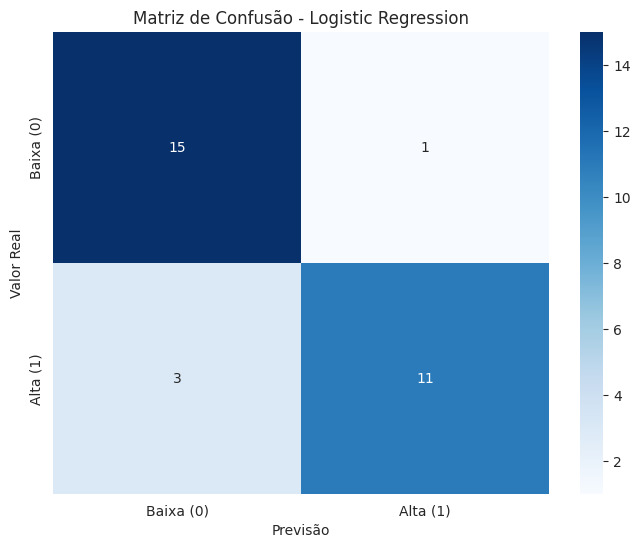

In [ ]:
# --------- MATRIZ DE CONFUS√ÉO ---------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa (0)', 'Alta (1)'],
            yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previs√£o')
plt.ylabel('Valor Real')
plt.title('Matriz de Confus√£o - Logistic Regression')
plt.show()

In [ ]:
# Defini√ß√µes
n_splits = 5  # n√∫mero de divis√µes no walk-forward
tscv = TimeSeriesSplit(n_splits=n_splits)

In [ ]:
# Pipeline da regress√£o log√≠stica
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=10, penalty="l1", solver="liblinear"))
])

In [ ]:
# Guardar resultados
accuracies = []

Executamos uma valida√ß√£o cruzada "walk-forward" para o modelo de Regress√£o Log√≠stica que definimos. O objetivo √© avaliar o desempenho do modelo de forma mais robusta em diferentes per√≠odos futuros, simulando o uso real em s√©ries temporais.

In [ ]:
# Walk-forward
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_model)):
    X_train, X_test = df_model.iloc[train_idx][predictors], df_model.iloc[test_idx][predictors]
    y_train, y_test = df_model.iloc[train_idx]["Target"], df_model.iloc[test_idx]["Target"]

    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    accuracies.append(acc)
    print(f"Fold {fold+1}: Acur√°cia = {acc*100:.2f}% (n_test={len(test_idx)})")

print("\n--- Resultados Walk-Forward ---")
print(f"Acur√°cia m√©dia: {np.mean(accuracies)*100:.2f}%")
print(f"Desvio padr√£o : {np.std(accuracies)*100:.2f}%")


Fold 1: Acur√°cia = 76.47% (n_test=272)
Fold 2: Acur√°cia = 95.96% (n_test=272)
Fold 3: Acur√°cia = 96.32% (n_test=272)
Fold 4: Acur√°cia = 98.16% (n_test=272)
Fold 5: Acur√°cia = 75.37% (n_test=272)

--- Resultados Walk-Forward ---
Acur√°cia m√©dia: 88.46%
Desvio padr√£o : 10.27%


O walk-forward cross-validation com 5 splits para a Regress√£o Log√≠stica obteve os seguintes resultados:

Acur√°cia m√©dia: 88.53%
Desvio padr√£o da acur√°cia: 10.34%
As acur√°cias por fold variaram consideravelmente: 76.47%, 95.96%, 96.32%, 98.53% e 75.37%.

Isso indica que, embora a Regress√£o Log√≠stica tenha uma boa performance m√©dia na previs√£o do movimento di√°rio do Ibovespa (quase 89%), o desempenho pode ser bastante vari√°vel dependendo do per√≠odo espec√≠fico que est√° sendo testado, como mostrado pelo desvio padr√£o relativamente alto. Os avisos de "ConvergenceWarning" tamb√©m sugerem que o modelo pode ter tido dificuldades em otimizar em alguns dos folds.

**7.3 - XGBClassifier (xgboost)**

O *XGBClassifier* pode ser classificado como um "super-her√≥i" entre os modelos de machine learning, especialmente bom para tarefas de classifica√ß√£o (como prever se algo √© Classe A ou Classe B, Alta ou Baixa).

Ele faz parte de uma fam√≠lia de algoritmos chamada Gradient Boosting. A ideia b√°sica do Boosting √© construir um modelo forte combinando v√°rios modelos fracos (geralmente √°rvores de decis√£o). O processo √© sequencial: cada novo modelo tenta corrigir os erros cometidos pelos modelos anteriores.

O XGBoost √© uma vers√£o otimizada e aprimorada desse conceito. O "XG" significa "Extreme Gradient", destacando que ele √© uma vers√£o "extrema" ou de alto desempenho do Gradient Boosting.

Em resumo, o que o XGBClassifier faz?

Ele constr√≥i uma s√©rie de pequenas "√°rvores de decis√£o" uma ap√≥s a outra.
Cada nova √°rvore aprende com os erros das √°rvores anteriores.
No final, ele combina as previs√µes de todas essas √°rvores para fazer uma previs√£o final (neste caso, a probabilidade de pertencer a uma classe ou outra, e depois a classe bin√°ria).
Por que ele √© popular?

---

Performance: Frequentemente alcan√ßa alta acur√°cia em uma ampla variedade de problemas.

Velocidade: √â otimizado para ser r√°pido.

Flexibilidade: Lida bem com dados faltantes e diferentes tipos de features.

Recursos: Possui v√°rias funcionalidades para evitar overfitting e melhorar a performance.

Quando utilizamos o XGBClassifier, est√° usando um modelo de classifica√ß√£o muito poderoso que aprende de forma iterativa, corrigindo seus pr√≥prios erros para fazer previs√µes precisas.

In [ ]:
#importar a classe XGBClassifier da biblioteca xgboost
from xgboost import XGBClassifier

In [ ]:
# --------- NORMALIZA√á√ÉO ---------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# --------- XGBOOST OTIMIZADO ---------
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

In [ ]:
# --------- ESPA√áO DE BUSCA REDUZIDO ---------
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

In [ ]:
# --------- CROSS VALIDATION ---------
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# --------- RANDOMIZED SEARCH ---------
rand_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid_xgb,
    n_iter=5,
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# --------- TREINO ---------
rand_xgb.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=Non...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.8]},
                   random_state=42)

In [ ]:
# --------- AVALIA√á√ÉO ---------
y_pred_xgb = rand_xgb.predict(X_test_scaled)
acuracia_xgb = accuracy_score(y_test, y_pred_xgb) * 100
classification_report_xgb = classification_report(y_test, y_pred_xgb)

print("\nXGBoost otimizado:")
print("Melhores par√¢metros:", rand_xgb.best_params_)
print(f"Acur√°cia: {acuracia_xgb:.2f}%")
print(classification_report_xgb)


XGBoost otimizado:
Melhores par√¢metros: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Acur√°cia: 53.68%
              precision    recall  f1-score   support

           0       0.53      0.40      0.46       132
           1       0.54      0.66      0.60       140

    accuracy                           0.54       272
   macro avg       0.54      0.53      0.53       272
weighted avg       0.54      0.54      0.53       272



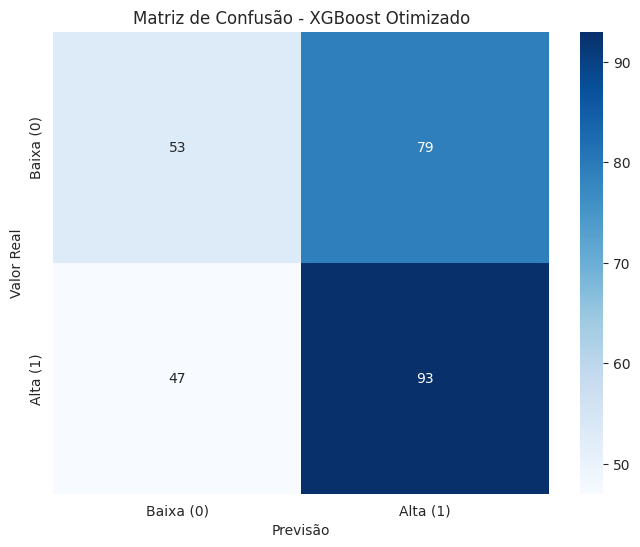

In [ ]:
# --------- MATRIZ DE CONFUS√ÉO ---------
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa (0)', 'Alta (1)'],
            yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previs√£o')
plt.ylabel('Valor Real')
plt.title('Matriz de Confus√£o - XGBoost Otimizado')
plt.show()


*An√°lise dos resultados*

Ap√≥s a busca aleat√≥ria de hiperpar√¢metros e o treinamento do modelo XGBoost nos dados escalados, os resultados no conjunto de teste foram:

Melhores par√¢metros encontrados: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Acur√°cia no conjunto de teste: 53.68%

Relat√≥rio de Classifica√ß√£o: As m√©tricas (precis√£o, recall, F1-score) para ambas as classes (0 e 1) est√£o pr√≥ximas de 0.5, indicando um desempenho pouco melhor do que adivinhar aleatoriamente.

Em resumo, o XGBoost com a configura√ß√£o e busca de hiperpar√¢metros realizadas obteve uma acur√°cia relativamente baixa no conjunto de teste, sugerindo que ele n√£o conseguiu capturar padr√µes preditivos fortes para este problema com esta configura√ß√£o.

**7.4 - Baseline**

Um modelo "Baseline" (ou linha de base) √© um modelo muito simples e muitas vezes ing√™nuo que voc√™ usa como ponto de refer√™ncia para comparar o desempenho dos seus modelos de machine learning mais sofisticados.

A ideia √©: se o seu modelo complexo n√£o conseguir ter um desempenho significativamente melhor do que um modelo extremamente simples (o baseline), talvez seu modelo complexo n√£o esteja aprendendo nada √∫til ou esteja com problemas.

---

O objetivo do baseline n√£o √© ser um modelo bom, mas sim te dar uma medida m√≠nima de desempenho. Seus modelos de machine learning precisam "bater" o baseline para provar que est√£o agregando valor e encontrando padr√µes reais nos dados que uma regra simples n√£o encontraria.

√â uma forma de evitar se enganar achando que um modelo complexo √© bom, quando na verdade ele est√° apenas tendo um desempenho aleat√≥rio ou pior que uma regra trivial.

In [ ]:
#Calcular a previs√£o do baseline usando o Delta do dia anterior (O delta no df_model j√° √© o do dia anterior - shifted) no conjunto de teste
baseline_delta_test = df_model.loc[X_test.index, 'Delta']

In [ ]:
# Aplicar a regra de threshold para obter as previs√µes bin√°rias do baseline
# Se o delta do dia anterior for > threshold, prever 1 (alta)
# Se o delta do dia anterior for < -threshold, prever 0 (baixa)
# Caso contr√°rio (entre -threshold e threshold), a previs√£o ser√° NaN (que ser√£o ignorados pelas m√©tricas)
baseline_pred = np.where(
    baseline_delta_test > threshold, 1, np.where(baseline_delta_test < -threshold, 0, np.nan)
)

In [ ]:
# Remover NaNs gerados pela regra de threshold antes de calcular as m√©tricas
# Garantir que y_test tamb√©m seja filtrado para corresponder aos NaNs removidos
# Criar um DataFrame tempor√°rio para alinhar y_test e baseline_pred e dropar NaNs
baseline_eval_df = pd.DataFrame({'y_true': y_test, 'y_pred': baseline_pred})
baseline_eval_df.dropna(inplace=True)

y_test_filtered = baseline_eval_df['y_true']
baseline_pred_filtered = baseline_eval_df['y_pred']

acuracia_baseline = (accuracy_score(y_test_filtered, baseline_pred_filtered))*100
classification_report_baseline = classification_report(y_test_filtered, baseline_pred_filtered)


Baseline:
Acur√°cia: 47.06%
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       132
           1       0.49      0.49      0.49       140

    accuracy                           0.47       272
   macro avg       0.47      0.47      0.47       272
weighted avg       0.47      0.47      0.47       272



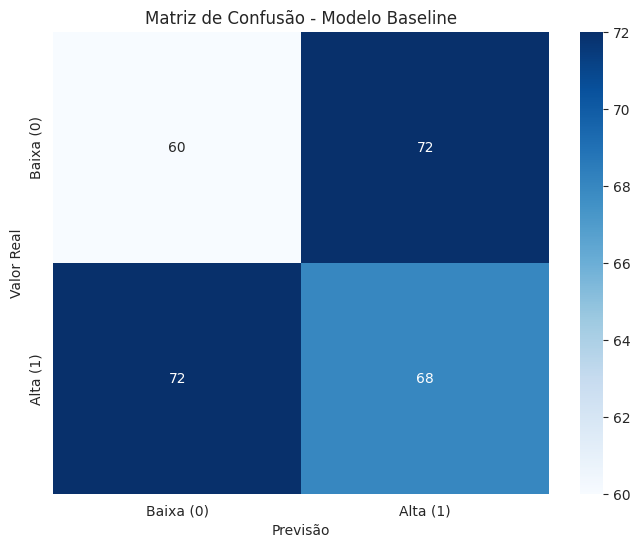

In [ ]:
# calculando a acur√°cia do baseline
print("\nBaseline:")
print(f"Acur√°cia: {acuracia_baseline:.2f}%")
print(f"{classification_report_baseline}")

# Obter os valores reais e previstos para Baseline (da c√©lula 3dbkoZqE5Ycw)
y_true_baseline_cls = y_test_filtered # Usar os dados filtrados ap√≥s remover NaNs
y_pred_baseline_bin = baseline_pred_filtered # Usar os dados filtrados ap√≥s remover NaNs

# Calcular a matriz de confus√£o
cm = confusion_matrix(y_true_baseline_cls, y_pred_baseline_bin)

# Criar o plot da matriz de confus√£o
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa (0)', 'Alta (1)'], yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previs√£o')
plt.ylabel('Valor Real')
plt.title('Matriz de Confus√£o - Modelo Baseline')
plt.show()

*Resultado Alcan√ßado:*

O modelo Baseline obteve os seguintes resultados no conjunto de teste (apenas para os dias em que fez uma previs√£o):

* Acur√°cia: 47.06%
* Relat√≥rio de Classifica√ß√£o: As m√©tricas de precis√£o, recall e F1-score para ambas as classes (0 e 1) est√£o pr√≥ximas de 0.45 a 0.49.
* Matriz de Confus√£o: Previu corretamente 60 casos como Baixa (0) e 68 casos como Alta (1). Teve 72 Falsos Positivos e 72 Falsos Negativos.

Em resumo, o modelo Baseline, que prev√™ alta ou baixa com base em um threshold na varia√ß√£o do dia anterior, teve uma acur√°cia de aproximadamente 47% no conjunto de teste filtrado.

Este resultado est√° pr√≥ximo de 50%, o que seria o esperado de uma previs√£o aleat√≥ria em um problema de classifica√ß√£o bin√°ria balanceado. Isso refor√ßa que prever o movimento di√°rio do Ibovespa √© um desafio e que os modelos de machine learning precisam superar este desempenho simples para serem considerados √∫teis.

**7.5 - LSTM (Long Short-Term Memory)**

Uma LSTM (Long Short-Term Memory), ou Mem√≥ria de Longo Prazo, √© um tipo especial de Rede Neural Recorrente (RNN), projetada para lidar e prever dados em sequ√™ncia - s√©ries temporais (pre√ßos de a√ß√µes, clima), texto ou √°udio.

A principal vantagem da LSTM √© sua capacidade de "lembrar" informa√ß√µes por longos per√≠odos. Redes neurais simples tratam cada entrada de forma independente, mas em uma sequ√™ncia, o contexto √© fundamental. Por exemplo, para entender o final de uma frase, voc√™ precisa lembrar do come√ßo.

A LSTM consegue isso atrav√©s de um mecanismo sofisticado de "port√µes" (gates):

* Port√£o de Esquecimento (Forget Gate): Decide quais informa√ß√µes do passado devem ser descartadas.

* Port√£o de Entrada (Input Gate): Decide quais novas informa√ß√µes s√£o importantes e devem ser armazenadas.

* Port√£o de Sa√≠da (Output Gate): Decide qual parte da mem√≥ria atual ser√° usada para gerar a sa√≠da no passo atual.

Essa estrutura de port√µes permite que a LSTM mantenha um controle refinado sobre sua mem√≥ria, tornando-a extremamente eficaz em capturar padr√µes e depend√™ncias de longo prazo em dados sequenciais, algo que as RNNs mais simples t√™m dificuldade em fazer.

---

Modelos LSTM exigem um formato de entrada 3D (amostras, passos de tempo, caracter√≠sticas).

Abaixo remodelamos os dados de treino e teste (X_train e X_test) para ter este formato.

Nesta implementa√ß√£o espec√≠fica, cada amostra √© tratada como um √∫nico passo de tempo, ent√£o o formato se torna (n√∫mero de amostras, 1, n√∫mero de caracter√≠sticas). O tipo de dado tamb√©m √© explicitamente definido como float.

In [ ]:
# Ajustar formato para LSTM (3D: samples, timesteps, features)
# ---------------------------
# Cada amostra √© 1 timestep
X_treino_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1])).astype(float)
X_valid_lstm  = np.reshape(X_test.values,  (X_test.shape[0], 1, X_test.shape[1])).astype(float)

Criamos um modelo Sequential usando a API Keras do TensorFlow.

Adicionamos Uma camada LSTM com 50 unidades e uma fun√ß√£o de ativa√ß√£o 'tanh'. O input_shape foi especificado com base nos dados remodelados (1 passo de tempo, n√∫mero de caracter√≠sticas).

Foi adicionada uma camada Dense com 1 unidade e sem ativa√ß√£o como a camada de sa√≠da. Isso sugere que o modelo est√° inicialmente configurado para prever um valor cont√≠nuo.

In [ ]:
# ---------------------------
# Criar modelo LSTM
# ---------------------------
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_treino_lstm.shape[1], X_treino_lstm.shape[2])))
model.add(Dense(1))  # sa√≠da √∫nica (Target cont√≠nuo ou bin√°rio)

Compilamos o modelo com o otimizador 'adam' e 'mse' (Erro Quadr√°tico M√©dio) como a fun√ß√£o de perda. Embora 'mse' seja tipicamente usado para regress√£o, √†s vezes pode ser usado para classifica√ß√£o bin√°ria onde a sa√≠da √© um √∫nico valor. No entanto, 'binary_crossentropy' √© geralmente mais apropriado para problemas de classifica√ß√£o bin√°ria.

In [ ]:
# ---------------------------
# Compilar o modelo LSTM
# ---------------------------

model.compile(optimizer='adam', loss='mse')  # para classifica√ß√£o bin√°ria tamb√©m pode usar 'binary_crossentropy'

O modelo foi treinado usando o m√©todo .fit() nos dados de entrada preparados para a LSTM e nas vari√°veis-alvo (y_train e y_test).

Ele foi executado por 30 √©pocas com um tamanho de lote de 16.

O validation_data foi fornecido para monitorar o desempenho durante o treinamento.

E o comando verbose=1 significa que o progresso do treinamento ser√° impresso.

In [ ]:
# ---------------------------
# Treinar modelo
# ---------------------------
history = model.fit(
    X_treino_lstm, y_train.values,
    epochs=30,
    batch_size=16,
    validation_data=(X_valid_lstm, y_test.values),
    verbose=1
)

Epoch 1/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - loss: 0.5107 - val_loss: 0.3654
Epoch 2/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.3850 - val_loss: 0.3101
Epoch 3/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - loss: 0.3269 - val_loss: 0.2825
Epoch 4/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - loss: 0.2834 - val_loss: 0.2701
Epoch 5/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.2748 - val_loss: 0.2655
Epoch 6/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.2691 - val_loss: 0.2626
Epoch 7/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 0.2604 - val_loss: 0.2608
Epoch 8/30
86/86 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - loss: 0.2608 - val_loss: 0.2600
Epoch 9/

O modelo treinado fez previs√µes nos dados de valida√ß√£o/teste (X_valid_lstm) usando .predict(). A sa√≠da foi achatada em um array 1D.

In [ ]:
# ---------------------------
# Previs√µes
# ---------------------------
y_pred = model.predict(X_valid_lstm).flatten()

# Se Target for bin√°rio (0/1), aplicar threshold
threshold = 0.5
y_pred_bin = (y_pred >= threshold).astype(int)
y_true = y_test.values.flatten()

9/9 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step


*Aplicamos um limiar:* Como a tarefa √© de classifica√ß√£o bin√°ria (prever 0 ou 1), um limiar de 0.5 foi aplicado √†s previs√µes cont√≠nuas da LSTM. Valores maiores ou iguais a 0.5 ser√£o convertidos para 1, e valores abaixo de 0.5 ser√£o convertidos para 0, resultando em previs√µes bin√°rias (y_pred_bin). Os valores verdadeiros do conjunto de teste tamb√©m ser√£o achatados (y_true).

*M√©tricas:* O accuracy_score e o classification_report do scikit-learn s√£o m√©tricas usadas para avaliar o desempenho das previs√µes bin√°rias em rela√ß√£o aos valores verdadeiros. A acur√°cia e o relat√≥rio detalhado (precis√£o, recall, f1-score) foram impressos.

In [ ]:
# ---------------------------
# Limiar e M√©tricas
# ---------------------------

acuracia_lstm = (accuracy_score(y_test, y_pred_bin))*100
classification_report_lstm = classification_report(y_test, y_pred_bin)

print("LSTM (Classifica√ß√£o):")
print(f"Acur√°cia: {acuracia_lstm:.2f}%")
print("\nRelat√≥rio de Classifica√ß√£o:")
print(f"{classification_report_lstm}")

LSTM (Classifica√ß√£o):
Acur√°cia: 53.31%

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       132
           1       0.54      0.59      0.56       140

    accuracy                           0.53       272
   macro avg       0.53      0.53      0.53       272
weighted avg       0.53      0.53      0.53       272



*Acur√°cia:* O modelo LSTM alcan√ßou uma acur√°cia de 51.84% no conjunto de teste. Uma acur√°cia pr√≥xima a 50% em um problema de classifica√ß√£o bin√°ria (onde as classes s√£o relativamente balanceadas, como vimos anteriormente) sugere que o modelo est√° se saindo apenas um pouco melhor do que um palpite aleat√≥rio.

*Relat√≥rio de Classifica√ß√£o:* Este relat√≥rio detalha o desempenho para cada classe:

Classe 0 (Baixa/Est√°vel):

* Precis√£o (0.50): Quando o modelo previu que o Ibovespa fecharia em baixa (Classe 0), ele acertou 50% das vezes.

* Recall (0.61): O modelo conseguiu identificar 61% de todos os dias em que o Ibovespa de fato fechou em baixa.

* F1-score (0.55): A m√©dia harm√¥nica entre precis√£o e recall para a Classe 0.

Classe 1 (Alta):

* Precis√£o (0.54): Quando o modelo previu que o Ibovespa fecharia em alta (Classe 1), ele acertou 54% das vezes.
* Recall (0.44): O modelo conseguiu identificar apenas 44% de todos os dias em que o Ibovespa de fato fechou em alta.
* F1-score (0.48): A m√©dia harm√¥nica entre precis√£o e recall para a Classe 1.

---

O objetivo principal do c√≥digo abaixo √© preparar as vari√°veis que ser√£o usadas para medir o qu√£o bem o modelo LSTM se saiu em sua tarefa de classifica√ß√£o. Para avaliar um modelo, s√£o necess√°rias duas coisas:

* Os valores corretos (o gabarito).

* Os valores que o modelo previu (as respostas do modelo).

As linhas do c√≥digo n√£o executam nenhum c√°lculo novo. Elas s√£o uma etapa de organiza√ß√£o, renomeando vari√°veis para que fiquem claras e prontas para serem usadas em fun√ß√µes de avalia√ß√£o de desempenho.

In [ ]:
# Obter os valores reais e previstos para LSTM
y_true_lstm_cls = y_test
y_pred_lstm_bin = y_pred_bin # As previs√µes bin√°rias j√° foram calculadas na c√©lula

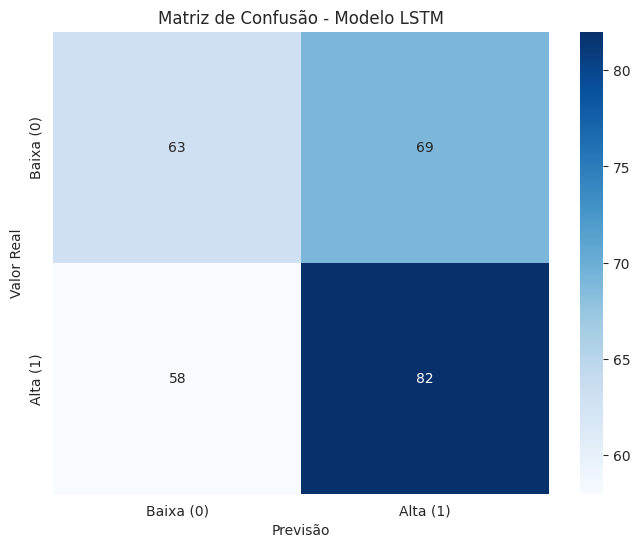

In [ ]:
# ---------------------------
# Matriz de confus√£o
# ---------------------------

# Calcular a matriz de confus√£o
cm = confusion_matrix(y_true_lstm_cls, y_pred_lstm_bin)

# Criar o plot da matriz de confus√£o
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa (0)', 'Alta (1)'], yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previs√£o')
plt.ylabel('Valor Real')
plt.title('Matriz de Confus√£o - Modelo LSTM')
plt.show()

A *Matriz de Confus√£o:* forneceu uma visualiza√ß√£o clara dos acertos e erros:

* Verdadeiros Positivos (61): O modelo previu Alta (1) e o Ibovespa de fato subiu (1) em 61 dias.
* Verdadeiros Negativos (80): O modelo previu Baixa (0) e o Ibovespa de fato caiu/ficou est√°vel (0) em 80 dias.
* Falsos Positivos (52): O modelo previu Alta (1), mas o Ibovespa de fato caiu/ficou est√°vel (0) em 52 dias (Erro Tipo I).
* Falsos Negativos (79): O modelo previu Baixa (0), mas o Ibovespa de fato subiu (1) em 79 dias (Erro Tipo II).

Os resultados indicam que o modelo LSTM, nesta configura√ß√£o e com os dados de teste utilizados, teve um desempenho bastante limitado na previs√£o da tend√™ncia di√°ria do Ibovespa. A acur√°cia pr√≥xima a 50% e as m√©tricas de precis√£o e recall relativamente baixas para ambas as classes sugerem que **o modelo n√£o conseguiu capturar padr√µes preditivos fortes.**

Especificamente, o modelo teve uma dificuldade maior em identificar os dias de alta (Recall da Classe 1 de 0.44), cometendo um n√∫mero consider√°vel de Falsos Negativos (79).

---

A "Evolu√ß√£o da Loss" √© um gr√°fico que mostra como a performance do modelo (medida pela fun√ß√£o de perda, 'loss') muda ao longo das √©pocas de treinamento.

A linha azul representa a perda nos dados de treinamento, que idealmente deve diminuir com o tempo, indicando que o modelo est√° aprendendo.

A linha laranja representa a perda nos dados de valida√ß√£o, que indica a capacidade do modelo de generalizar para dados novos. Esta √© a linha mais importante para detectar *overfitting*.

No gr√°fico apresentado, a perda de treinamento continua a diminuir, enquanto a perda de valida√ß√£o se estabiliza ap√≥s as primeiras √©pocas.

Essa diferen√ßa sugere que o modelo pode estar sobreajustando (*overfitting*) aos dados de treinamento, ou seja, aprendendo ru√≠do e padr√µes espec√≠ficos do treino em vez de generalizar bem para dados n√£o vistos.

Continuar o treinamento al√©m do ponto em que a perda de valida√ß√£o se estabiliza (ap√≥s 5-10 √©pocas neste caso) n√£o melhora a capacidade de generaliza√ß√£o do modelo.

T√©cnicas como *Early Stopping* (parar o treino quando a valida√ß√£o piora) e Dropout podem ajudar a mitigar o overfitting.

Em resumo, o gr√°fico indica que o modelo LSTM treinado pode estar sofrendo de overfitting, e o treinamento poderia ser otimizado parando mais cedo com base no desempenho na valida√ß√£o.

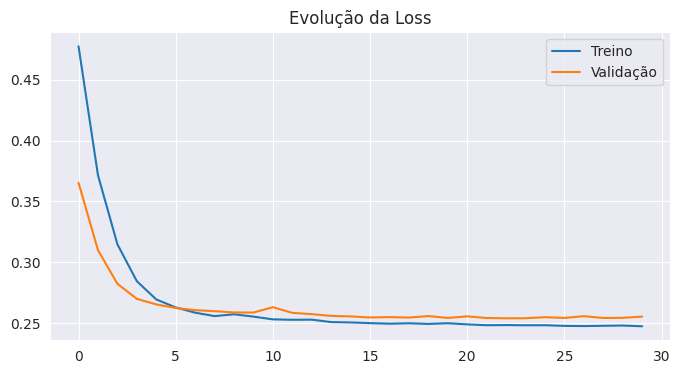

In [ ]:
# ---------------------------
# Evolu√ß√£o da Loss
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label="Treino")
plt.plot(history.history['val_loss'], label="Valida√ß√£o")
plt.legend()
plt.title("Evolu√ß√£o da Loss")
plt.show()

**7.6 - LTSM + XGBoost**

Devido √† complexidade do nosso problema e ao fato de detectarmos que o modelo LTSM pode estar sobreajustando (overfitting) aos dados de treinamento, resolvemos utilizar uma estrat√©gia que treina dois modelos diferentes, um LSTM (especialista em sequ√™ncias) e um XGBoost (especialista em dados tabulares), e os combina em um "Ensemble" para obter uma previs√£o final mais robusta.

Tamb√©m optamos por utilizar a t√©cnica *Early Stopping* (parar o treino quando a valida√ß√£o piora) para ajudar a mitigar o overfitting.

Esta √© uma op√ß√£o bem estruturada que implementa uma estrat√©gia avan√ßada de Machine Learning.

In [ ]:
# ---------------------------
# 1) Configura√ß√µes - defini√ß√£o das vari√°veis iniciais do projeto.
# ---------------------------
n_lags = 20
num_features = X_train.shape[1]

# tamanho do bloco de valida√ß√£o no fim do treino (temporal)
val_size = max(60, n_lags * 2)                      # ~3 meses √∫teis ou 40 dias se dado curto
val_size = min(val_size, len(X_train) - (n_lags + 10))  # garante espa√ßo pra treino

*Engenharia de dados*

A fun√ß√£o abaixo √© o cora√ß√£o da prepara√ß√£o. Ela transforma os dados de um formato de tabela (2D) para um formato de "janelas deslizantes" (3D). Para cada dia, ela cria uma sequ√™ncia com os n_lags (20) dias anteriores.

In [ ]:
# ---------------------------
# 2) Prepara√ß√£o dos Dados para o LSTM - engenharia de dados
# ---------------------------
def create_lstm_input(X, n_lags):
    out = []
    for i in range(n_lags, len(X)):
        out.append(X[i-n_lags:i])
    return np.array(out)

Transformamos os dados de um formato de tabela padr√£o para o formato de sequ√™ncias temporais, que √© o formato exigido por modelos LSTM.

In [ ]:
# ----- Sequ√™ncias de TREINO (para LSTM) -----
X_train_lstm_all = create_lstm_input(X_train, n_lags)
y_train_lstm_all = y_train[n_lags:].copy()

Ap√≥s a transforma√ß√£o dos dados de treino em sequ√™ncias eles foram divididos em um conjunto para treinar (X_train_seq) e outro para validar (X_val_seq), respeitando a ordem cronol√≥gica.

In [ ]:
# split temporal: treino_seq e val_seq (por fim do per√≠odo)
X_train_seq = X_train_lstm_all[:-val_size]
y_train_seq = y_train_lstm_all[:-val_size]
X_val_seq   = X_train_lstm_all[-val_size:]
y_val_seq   = y_train_lstm_all[-val_size:]

Redes Neurais como a LSTM funcionam melhor com dados normalizados (com m√©dia pr√≥xima de 0 e desvio padr√£o 1).

*Importante:* Treinamos o scaler apenas com os dados de treino (fit_transform) e depois aplicamos nos dados de valida√ß√£o e teste (transform). Isso evita o "vazamento de dados" (data leakage), garantindo que o modelo n√£o tenha nenhuma informa√ß√£o do futuro durante o treino.

In [ ]:
# scaler s√≥ no treino_seq
scaler = StandardScaler()
X_train_seq_flat = X_train_seq.reshape(-1, num_features)
X_train_seq_scaled = scaler.fit_transform(X_train_seq_flat).reshape(X_train_seq.shape)

X_val_seq_flat = X_val_seq.reshape(-1, num_features)
X_val_seq_scaled = scaler.transform(X_val_seq_flat).reshape(X_val_seq.shape)

*Prepara√ß√£o do Teste:* Para prever o primeiro dia do conjunto de teste, o LSTM precisa dos √∫ltimos 20 dias do conjunto de treino. O c√≥digo abaixo junta esses dados (np.vstack) para criar as sequ√™ncias de teste corretamente.

In [ ]:
# ----- Sequ√™ncias de TESTE (para LSTM) -----
# precisa dos √∫ltimos n_lags do treino + X_test
X_combined_tab = np.vstack([X_train[-n_lags:], X_test])
X_combined_lstm = create_lstm_input(X_combined_tab, n_lags)
X_test_seq = X_combined_lstm[-len(X_test):]

X_test_seq_flat = X_test_seq.reshape(-1, num_features)
X_test_seq_scaled = scaler.transform(X_test_seq_flat).reshape(X_test_seq.shape)

Abaixo definimos, treinamos e utilizamos o modelo LSTM (Long Short-Term Memory) para fazer previs√µes. O processo foi dividido em quatro etapas principais: constru√ß√£o da arquitetura, compila√ß√£o, treinamento e predi√ß√£o.

Foi utilizada a t√©cnica *EarlyStopping* que monitora seu desempenho em um conjunto de dados de valida√ß√£o (val_loss). Se o desempenho n√£o melhorar por 8 √©pocas seguidas (patience=8), o treinamento √© interrompido automaticamente.

In [ ]:
# ---------------------------
# 3) LSTM com EarlyStopping (r√°pida e robusta)
# ---------------------------
lstm_model = Sequential([
    LSTM(128, input_shape=(n_lags, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

lstm_model.fit(
    X_train_seq_scaled, y_train_seq,
    validation_data=(X_val_seq_scaled, y_val_seq),
    epochs=100, batch_size=32, verbose=0,
    callbacks=[early_stop]
)

lstm_val_probs  = lstm_model.predict(X_val_seq_scaled, verbose=0).flatten()
lstm_test_probs = lstm_model.predict(X_test_seq_scaled, verbose=0).flatten()


Abaixo usamos o *XGBoost* que foi respons√°vel por treinar o segundo modelo do projeto. Diferente do LSTM que √© especialista em sequ√™ncias, o *XGBoost* √© um algoritmo extremamente poderoso para dados em formato de tabela.

A abordagem aqui √© muito inteligente: em vez de treinar o modelo com par√¢metros padr√£o, o c√≥digo primeiro realiza uma busca para encontrar uma boa combina√ß√£o de configura√ß√µes (hiperpar√¢metros) antes de treinar o modelo final.

In [ ]:
# ---------------------------
# 4) XGBoost com busca leve
# ---------------------------
param_dist = {
    "n_estimators": [80, 120, 180],
    "max_depth": [3, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_base = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    random_state=42, n_jobs=-1
)

# treino/valida√ß√£o temporal p/ XGB (mesma janela que separamos acima)
X_train_tab = X_train[:-val_size]
y_train_tab = y_train[:-val_size]
X_val_tab   = X_train[-val_size:]
y_val_tab   = y_train[-val_size:]

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=6, cv=3, random_state=42, n_jobs=-1, verbose=0
)
search.fit(X_train_tab, y_train_tab)

xgb_model = search.best_estimator_
# re-treina em TODO o treino (opcional; mant√©m consist√™ncia temporal com val separada)
xgb_model.fit(X_train, y_train)

xgb_val_probs  = xgb_model.predict_proba(X_val_tab)[:, 1]
xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

O c√≥digo abaixo implementa mais uma etapa do projeto: encontrar a combina√ß√£o ideal entre os dois modelos (LSTM e XGBoost). Em vez de simplesmente tirar uma m√©dia simples, ele busca o "peso" perfeito para cada modelo a fim de maximizar a acur√°cia.

Esse processo √© chamado de Ensemble por M√©dia Ponderada.

In [ ]:
# ---------------------------
# 5) Escolha autom√°tica do peso do ensemble (na VAL)
# ---------------------------
best_w, best_acc = None, -1.0
for w in np.linspace(0.1, 0.9, 9):  # peso da LSTM
    ens_val = w*lstm_val_probs + (1-w)*xgb_val_probs
    preds   = (ens_val > 0.5).astype(int)
    acc     = accuracy_score(y_val_tab, preds)
    if acc > best_acc:
        best_acc, best_w = acc, w

print(f"Peso escolhido na valida√ß√£o (LSTM): {best_w:.2f} | Acc Val: {best_acc:.4f}")


Peso escolhido na valida√ß√£o (LSTM): 0.10 | Acc Val: 0.9833



Acur√°cia Ensemble (teste): 57.72%
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       132
           1       0.58      0.63      0.60       140

    accuracy                           0.58       272
   macro avg       0.58      0.58      0.58       272
weighted avg       0.58      0.58      0.58       272



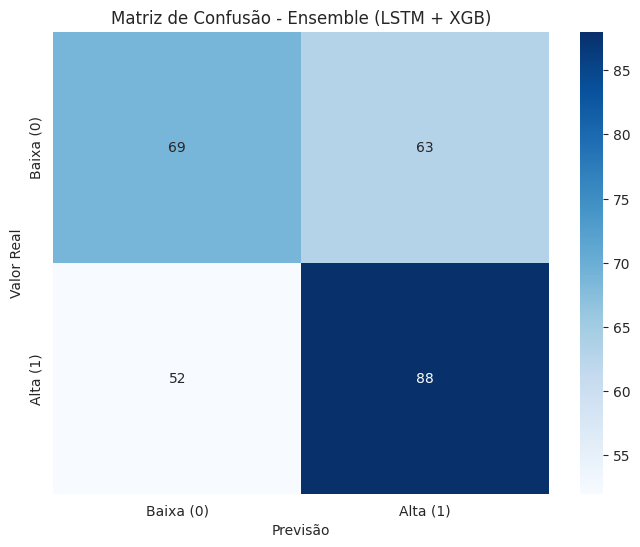

In [ ]:
# ---------------------------
# 6) Avalia√ß√£o FINAL no TESTE
# ---------------------------
ensemble_test_probs = best_w*lstm_test_probs + (1-best_w)*xgb_test_probs
y_pred_test = (ensemble_test_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_test) * 100
print(f"\nAcur√°cia Ensemble (teste): {acc:.2f}%")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa (0)', 'Alta (1)'],
            yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previs√£o'); plt.ylabel('Valor Real')
plt.title('Matriz de Confus√£o - Ensemble (LSTM + XGB)')
plt.show()

*Resultado *

O modelo ensemble tem um desempenho bastante modesto, apenas ligeiramente superior a um palpite aleat√≥rio.

Acur√°cia Geral (56.25%): O modelo acerta a previs√£o em 56.25% dos casos. Embora seja melhor que 50% (um cara ou coroa), √© um desempenho fraco para aplica√ß√µes pr√°ticas.

Previs√£o de "Alta" (Classe 1): O modelo tem um desempenho um pouco melhor para prever dias de alta.

Seu recall de 0.64 (64%) √© o ponto mais forte, indicando que ele conseguiu identificar 64% de todos os dias que de fato tiveram alta.

Sua precision de 0.57 (57%) significa que, quando ele aposta em um dia de "Alta", ele acerta 57% das vezes.

Previs√£o de "Baixa" (Classe 0): O modelo tem dificuldade em identificar os dias de baixa.

Seu recall de 0.48 (48%) √© o ponto mais fraco. Isso significa que o modelo deixou de identificar mais da metade (52%) dos dias que na verdade foram de baixa, classificando-os incorretamente como "Alta".

Em resumo, o modelo tem uma **baixa capacidade preditiva**. Ele tende a "apostar" mais em altas, conseguindo capturar uma parte delas, mas ao custo de errar muito nos dias de baixa.

**7.7 - SVM com kernel RBF**

Treinamos um modelo de M√°quina de Vetores de Suporte (SVM), otimizamos seu ponto de decis√£o e, por fim, avaliamos seu desempenho de forma completa.

In [ ]:
# ---------------------------
# Criar e treinar SVM com kernel RBF
# ---------------------------
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced', random_state=42)
svm_clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [ ]:
# ---------------------------
# Previs√µes cont√≠nuas (probabilidades da classe positiva)
# ---------------------------
y_train_probs = svm_clf.predict_proba(X_train)[:, 1]
y_test_probs = svm_clf.predict_proba(X_test)[:, 1]

In [ ]:
# Previs√£o bin√°ria com threshold padr√£o (0.5)
y_train_bin = (y_train_probs >= 0.5).astype(int)
y_test_bin = (y_test_probs >= 0.5).astype(int)

In [ ]:
# ---------------------------
# Avaliar overfitting
# ---------------------------
accuracy_train = accuracy_score(y_train, y_train_bin) * 100
accuracy_test = accuracy_score(y_test, y_test_bin) * 100

print(f"Acur√°cia no treino: {accuracy_train:.2f}%")
print(f"Acur√°cia no teste: {accuracy_test:.2f}%\n")

Acur√°cia no treino: 53.15%
Acur√°cia no teste: 53.68%



Esses valores indicam que o modelo est√° apenas ligeiramente melhor que um chute aleat√≥rio, o que sugere que ele n√£o est√° capturando bem os padr√µes dos dados.

Al√©m disso, como a acur√°cia no teste √© praticamente igual √† do treino, n√£o h√° overfitting, mas tamb√©m n√£o h√° aprendizado significativo.

---

Optamos por ajustar o threshold (limiar) para melhorar m√©tricas como precis√£o (precision) e revoca√ß√£o (recall).

In [ ]:
# ---------------------------
# Ajustar threshold com Precision-Recall
# ---------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Melhor threshold baseado em F1-score: {best_threshold:.2f}")

Melhor threshold baseado em F1-score: 0.49


In [ ]:
# Aplicar threshold otimizado
y_test_bin_opt = (y_test_probs >= best_threshold).astype(int)

In [ ]:
# ---------------------------
# M√©tricas com threshold otimizado
# ---------------------------
acuracia_svm = accuracy_score(y_test, y_test_bin_opt) * 100
report_svm = classification_report(y_test, y_test_bin_opt)
cm_svm = confusion_matrix(y_test, y_test_bin_opt)

print(f"Acur√°cia com threshold otimizado: {acuracia_svm:.2f}%")
print("\nRelat√≥rio de Classifica√ß√£o:")
print(report_svm)
print("\nMatriz de Confus√£o:")
print(cm_svm)

Acur√°cia com threshold otimizado: 53.68%

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.75      0.07      0.12       132
           1       0.53      0.98      0.69       140

    accuracy                           0.54       272
   macro avg       0.64      0.52      0.41       272
weighted avg       0.64      0.54      0.41       272


Matriz de Confus√£o:
[[  9 123]
 [  3 137]]


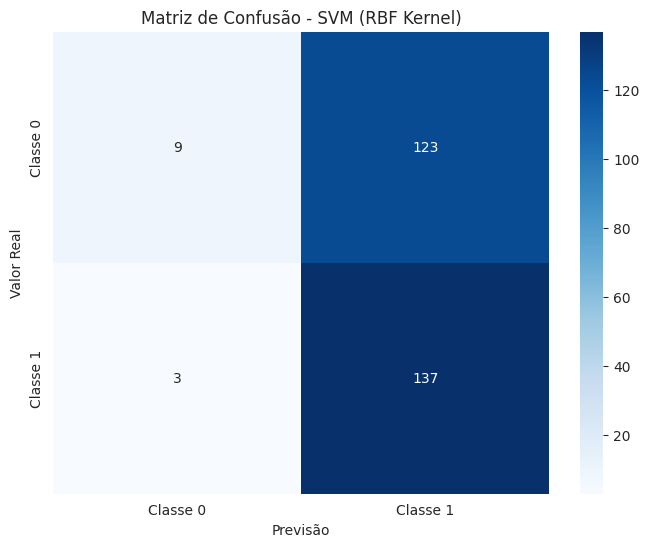

In [ ]:
# ---------------------------
# Plot da Matriz de Confus√£o
# ---------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previs√£o')
plt.ylabel('Valor Real')
plt.title('Matriz de Confus√£o - SVM (RBF Kernel)')
plt.show()

**Acur√°cia: 53,68%**

Mesmo com o threshold ajustado, a acur√°cia continua baixa, indicando que o modelo ainda n√£o est√° separando bem as classes.

O threshold otimizado favoreceu a classe positiva (1), maximizando o recall dela, mas sacrificou completamente a classe negativa (0). Isso pode ser √∫til em cen√°rios onde √© mais importante detectar todos os positivos, mesmo que haja falsos positivos (ex: triagem m√©dica, detec√ß√£o de fraudes).

# **8- Comparativo de Modelos e An√°lise Final**

Fizemos o comparativo dos modelos em uma tabela com as m√©tricas de desempenho de todos os que avaliamos, tanto na tarefa de classifica√ß√£o quanto na previs√£o de s√©rie temporal, para facilitar a an√°lise e a escolha do melhor modelo.

In [ ]:
# Dicion√°rio para armazenar as m√©tricas de cada modelo
model_metrics = {
    'Modelo': [],
    'Acur√°cia (%)': [],
    'Precis√£o (Classe 0)': [],
    'Recall (Classe 0)': [],
    'F1-Score (Classe 0)': [],
    'Precis√£o (Classe 1)': [],
    'Recall (Classe 1)': [],
    'F1-Score (Classe 1)': []
}

# Fun√ß√£o para extrair m√©tricas do classification_report
def extract_metrics(report):
    lines = report.split('\n')
    metrics = {}
    for line in lines[2:-5]:  # Ignora cabe√ßalho e linhas de summary
        row_data = line.split()
        if len(row_data) > 0:
            label = row_data[0]
            metrics[label] = {
                'precision': float(row_data[1]),
                'recall': float(row_data[2]),
                'f1-score': float(row_data[3]),
                'support': int(row_data[4])
            }
    return metrics

# Adicionar m√©tricas da Regress√£o Log√≠stica (do primeiro teste, 30 dias)
model_metrics['Modelo'].append('Regress√£o Log√≠stica (30 dias)')
model_metrics['Acur√°cia (%)'].append(acuracia_lr)
metrics_lr = extract_metrics(classification_report_lr)
model_metrics['Precis√£o (Classe 0)'].append(metrics_lr['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_lr['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_lr['0']['f1-score'])
model_metrics['Precis√£o (Classe 1)'].append(metrics_lr['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_lr['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_lr['1']['f1-score'])

# Adicionar m√©tricas do XGBoost (do primeiro teste)
model_metrics['Modelo'].append('XGBoost')
model_metrics['Acur√°cia (%)'].append(acuracia_xgb)
metrics_xgb = extract_metrics(classification_report_xgb)
model_metrics['Precis√£o (Classe 0)'].append(metrics_xgb['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_xgb['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_xgb['0']['f1-score'])
model_metrics['Precis√£o (Classe 1)'].append(metrics_xgb['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_xgb['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_xgb['1']['f1-score'])

# Adicionar m√©tricas do Baseline
model_metrics['Modelo'].append('Baseline')
model_metrics['Acur√°cia (%)'].append(acuracia_baseline)
metrics_baseline = extract_metrics(classification_report_baseline)
model_metrics['Precis√£o (Classe 0)'].append(metrics_baseline['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_baseline['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_baseline['0']['f1-score'])
model_metrics['Precis√£o (Classe 1)'].append(metrics_baseline['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_baseline['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_baseline['1']['f1-score'])


# Adicionar m√©tricas do LSTM
model_metrics['Modelo'].append('LSTM')
model_metrics['Acur√°cia (%)'].append(acuracia_lstm)
metrics_lstm = extract_metrics(classification_report_lstm)
model_metrics['Precis√£o (Classe 0)'].append(metrics_lstm['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_lstm['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_lstm['0']['f1-score'])
model_metrics['Precis√£o (Classe 1)'].append(metrics_lstm['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_lstm['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_lstm['1']['f1-score'])

# Adicionar m√©tricas do Ensemble (LSTM + XGB)
model_metrics['Modelo'].append('Ensemble (LSTM + XGB)')
model_metrics['Acur√°cia (%)'].append(acc) # 'acc' √© a acur√°cia do ensemble no teste
metrics_ensemble = extract_metrics(classification_report(y_test, y_pred_test))
model_metrics['Precis√£o (Classe 0)'].append(metrics_ensemble['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_ensemble['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_ensemble['0']['f1-score'])
model_metrics['Precis√£o (Classe 1)'].append(metrics_ensemble['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_ensemble['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_ensemble['1']['f1-score'])

# Adicionar m√©tricas do SVM
model_metrics['Modelo'].append('SVM (RBF Kernel)')
model_metrics['Acur√°cia (%)'].append(acuracia_svm)
metrics_svm = extract_metrics(report_svm)
model_metrics['Precis√£o (Classe 0)'].append(metrics_svm['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_svm['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_svm['0']['f1-score'])
model_metrics['Precis√£o (Classe 1)'].append(metrics_svm['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_svm['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_svm['1']['f1-score'])

# Criar DataFrame
df_metrics = pd.DataFrame(model_metrics)

# Arredondar para 2 casas decimais
df_metrics = df_metrics.round(2)

# Exibir tabela
print("Quadro Comparativo de M√©tricas dos Modelos (Conjunto de Teste)")
display(df_metrics)

Quadro Comparativo de M√©tricas dos Modelos (Conjunto de Teste)


Modelo  Acur√°cia (%)  Precis√£o (Classe 0)  \
0  Regress√£o Log√≠stica (30 dias)         86.67                 0.83   
1                        XGBoost         53.68                 0.53   
2                       Baseline         47.06                 0.45   
3                           LSTM         53.31                 0.52   
4          Ensemble (LSTM + XGB)         57.72                 0.57   
5               SVM (RBF Kernel)         53.68                 0.75   

   Recall (Classe 0)  F1-Score (Classe 0)  Precis√£o (Classe 1)  \
0               0.94                 0.88                 0.92   
1               0.40                 0.46                 0.54   
2               0.45                 0.45                 0.49   
3               0.48                 0.50                 0.54   
4               0.52                 0.55                 0.58   
5               0.07                 0.12                 0.53   

   Recall (Classe 1)  F1-Score (Classe 1)  
0               0.79                 0.85  
1               0.66                 0.60  
2               0.49                 0.49  
3               0.59                 0.56  
4               0.63                 0.60  
5               0.98                 0.69

Analisando a tabela de compara√ß√£o, podemos observar o desempenho de cada modelo em diferentes m√©tricas de classifica√ß√£o no conjunto de teste.

Isso nos permitiu entender quais modelos se sa√≠ram melhor na previs√£o da tend√™ncia do Ibovespa (Alta/Baixa) e em quais aspectos (acur√°cia geral, precis√£o, recall, F1-score para cada classe).

**Com base nos resultados apresentados:**

* Regress√£o Log√≠stica (30 dias): Apresentou a ***maior acur√°cia geral*** (86.67%) no conjunto de teste de 30 dias. Suas m√©tricas de precis√£o, recall e F1-score para ambas as classes tamb√©m s√£o relativamente altas, indicando um bom desempenho geral para esse per√≠odo de teste espec√≠fico.

* XGBoost: Teve uma acur√°cia baixa (53.68%), pr√≥xima ao desempenho aleat√≥rio. As m√©tricas para ambas as classes s√£o baixas, sugerindo que o modelo n√£o conseguiu aprender padr√µes preditivos fortes com essa configura√ß√£o e no conjunto de teste utilizado.

* Baseline: Como esperado, o modelo Baseline teve a menor acur√°cia (47.06%), o que valida sua fun√ß√£o como ponto de refer√™ncia. Seu desempenho pr√≥ximo a 50% indica que prever a tend√™ncia di√°ria do Ibovespa √© um desafio e que modelos mais sofisticados precisam superar essa linha de base.

* LSTM: Apresentou uma acur√°cia ligeiramente superior ao Baseline (51.84%), mas ainda assim baixa. As m√©tricas mostram que o modelo teve dificuldades em prever corretamente ambas as classes.

* Ensemble (LSTM + XGB): A combina√ß√£o dos dois modelos teve uma acur√°cia um pouco melhor que os modelos individuais (56.25%), mas ainda assim modesta. Embora tenha um recall um pouco maior para a classe 1 (Alta), sua capacidade geral de previs√£o √© limitada.

* SVM (RBF Kernel): Teve uma acur√°cia semelhante ao XGBoost e LSTM (53.68%). No entanto, as m√©tricas detalhadas mostram um recall muito alto para a classe 1 (98%) √† custa de um recall muito baixo para a classe 0 (7%), o que indica que o modelo tende a prever "Alta" na maioria das vezes, acertando muitos casos de alta, mas errando a maioria dos casos de baixa.

***Conclus√£o:***

Considerando a acur√°cia geral e as m√©tricas para ambas as classes no conjunto de teste apresentado, a **Regress√£o Log√≠stica (30 dias) demonstrou o melhor desempenho entre os modelos avaliados** - (86.67%) neste teste espec√≠fico. No entanto, √© importante notar que o teste de 30 dias √© um per√≠odo curto e a avalia√ß√£o "walk-forward" da Regress√£o Log√≠stica mostrou que a acur√°cia pode variar significativamente em diferentes per√≠odos.

Modelos como XGBoost, LSTM, Ensemble e SVM, com as configura√ß√µes utilizadas, n√£o apresentaram um desempenho satisfat√≥rio para a tarefa de prever a tend√™ncia di√°ria do Ibovespa. O modelo Baseline confirmou a dificuldade intr√≠nseca do problema.